In [144]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho các biểu đồ
sns.set_style("whitegrid")  # Using direct seaborn styling instead of plt.style.use
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

file_path = '../dataset/train_segmented.csv'
df = pd.read_csv(file_path)

# Create a copy of the original dataframe for later reference
df_original = df.copy()

In [145]:
def visualize_category_pooling(df, column, threshold=0.01, max_display=20, figsize=(16, 7)):
    """
    Visualize the distribution of a categorical variable before and after pooling rare categories.
    
    Parameters:
    -----------
    df : DataFrame
        The original DataFrame
    column : str
        The column name to visualize
    threshold : float
        The threshold used for pooling (default: 0.01)
    max_display : int
        Maximum number of categories to display in the bar charts
    figsize : tuple
        Figure size (width, height)
    """
    # Calculate the actual count threshold
    count_threshold = int(threshold * len(df))
    
    # Original distribution
    value_counts_original = df[column].value_counts()
    
    # Apply pooling
    pooled_series = pool_categories(df[column], threshold)
    value_counts_pooled = pooled_series.value_counts()
    
    # Determine how many categories to show (top categories)
    n_display = min(max_display, len(value_counts_original))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Left plot: Original distribution (top categories)
    top_cats_original = value_counts_original.nlargest(n_display)
    colors_original = ['red' if count < count_threshold else 'skyblue' for count in top_cats_original]
    
    top_cats_original.plot(kind='bar', ax=axes[0], color=colors_original)
    axes[0].set_title(f'Top {n_display} Categories (Original)\n{column}: {len(value_counts_original)} unique values', fontsize=12)
    axes[0].set_ylabel('Count')
    axes[0].axhline(y=count_threshold, color='red', linestyle='--')
    axes[0].text(0, count_threshold * 1.05, f'Threshold ({threshold*100:.1f}%): {count_threshold} samples', 
                color='red')
    axes[0].tick_params(axis='x', rotation=90)
    
    # Right plot: Pooled distribution (showing up to max_display categories)
    n_display_pooled = min(max_display, len(value_counts_pooled))
    top_cats_pooled = value_counts_pooled.nlargest(n_display_pooled)
    colors_pooled = ['red' if cat == 'Other' else 'skyblue' for cat in top_cats_pooled.index]
    
    top_cats_pooled.plot(kind='bar', ax=axes[1], color=colors_pooled)
    axes[1].set_title(f'Top {n_display_pooled} Categories (After Pooling)\n{column}: {len(value_counts_pooled)} unique values', fontsize=12)
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    n_rare_cats = sum(value_counts_original < count_threshold)
    rare_samples = sum(value_counts_original[value_counts_original < count_threshold])
    
    print(f"Summary for {column}:")
    print(f"- Original unique values: {len(value_counts_original)}")
    print(f"- Categories below threshold ({threshold*100:.1f}%): {n_rare_cats} categories ({n_rare_cats/len(value_counts_original)*100:.1f}%)")
    print(f"- Samples in rare categories: {rare_samples} samples ({rare_samples/len(df)*100:.1f}% of data)")
    print(f"- After pooling: {len(value_counts_pooled)} unique values ({len(value_counts_pooled)/len(value_counts_original)*100:.1f}% of original)")
    
    if 'Other' in value_counts_pooled:
        print(f"- 'Other' category contains {value_counts_pooled['Other']} samples ({value_counts_pooled['Other']/len(df)*100:.1f}% of data)")

In [146]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Xác định các loại cột
numerical_cols = ['case_thickness', 'case_diameter', 'water_resistance']
onehot_cols = ['gender', 'movement', 'watch_style']
categorical_cols = ['case_material', 'band_material', 'case_back', 'bezel_material', 
                    'brand', 'crystal', 'hands', 'dial_markers']

all_categorical_cols = onehot_cols + categorical_cols
high_card_cols = [col for col in all_categorical_cols if df[col].nunique() > 10]
low_card_cols = [col for col in all_categorical_cols if col not in high_card_cols]

# Category pooling (gộp nhóm các giá trị hiếm) - quan trọng cho Agglomerative Clustering
def pool_categories(series, threshold=0.01):
    value_counts = series.value_counts(normalize=True)
    rare = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

# Gộp giá trị hiếm cho các cột có nhiều category
df_processed = df.copy()
for col in high_card_cols:
    df_processed[col] = pool_categories(df_processed[col])

# Frequency Encoding cho các cột có nhiều category sau khi đã gộp
for col in high_card_cols:
    freq_map = df_processed[col].value_counts(normalize=True).to_dict()
    df_processed[col] = df_processed[col].map(freq_map)

# One-hot Encoding cho các cột có ít category
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
if low_card_cols:
    onehot_encoded = pd.DataFrame(
        onehot_encoder.fit_transform(df_processed[low_card_cols]),
        columns=onehot_encoder.get_feature_names_out(low_card_cols)
    )
    
    # Chuẩn hóa dữ liệu số - cần thiết cho Agglomerative Clustering
    scaler = StandardScaler()
    scaled_numerical = pd.DataFrame(
        scaler.fit_transform(df_processed[numerical_cols]),
        columns=numerical_cols
    )
    
    # Kết hợp dữ liệu đã xử lý
    df_gmm = pd.concat([
        scaled_numerical,
        onehot_encoded,
        df_processed[high_card_cols]
    ], axis=1)
else:
    # Chuẩn hóa dữ liệu số
    scaler = StandardScaler()
    scaled_numerical = pd.DataFrame(
        scaler.fit_transform(df_processed[numerical_cols]),
        columns=numerical_cols
    )
    
    # Kết hợp dữ liệu đã xử lý
    df_gmm = pd.concat([
        scaled_numerical,
        df_processed[high_card_cols]
    ], axis=1)

print("\n=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CHO AGGLOMERATIVE CLUSTERING ===")
print("\nDữ liệu đã được chuẩn hóa và mã hóa:")
print(df_gmm.head())
print(f"\nKích thước dữ liệu: {df_gmm.shape}")

# Lưu dữ liệu đã xử lý
df_gmm.to_csv('../dataset/train_agglomerative_processed.csv', index=False)

df_agg = df_gmm.copy()


=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CHO AGGLOMERATIVE CLUSTERING ===

Dữ liệu đã được chuẩn hóa và mã hóa:
   case_thickness  case_diameter  water_resistance  gender_UNISEX  \
0       -0.962829      -0.767582         -0.281839            0.0   
1       -0.687852      -0.097288         -0.281839            0.0   
2        0.215643       1.075727          0.006708            0.0   
3       -1.316370      -1.437877         -0.397257            0.0   
4       -0.021551       0.237859         -0.281839            0.0   

   gender_WOMENS  movement_Eco-Drive  movement_Hand Wind  movement_Quartz  \
0            1.0                 0.0                 0.0              0.0   
1            0.0                 0.0                 0.0              1.0   
2            0.0                 0.0                 0.0              1.0   
3            1.0                 0.0                 0.0              1.0   
4            0.0                 0.0                 0.0              1.0   

   watch_s

High cardinality columns (> 10 unique values): ['case_material', 'band_material', 'case_back', 'bezel_material', 'brand', 'crystal', 'hands', 'dial_markers']

Analyzing column: case_material


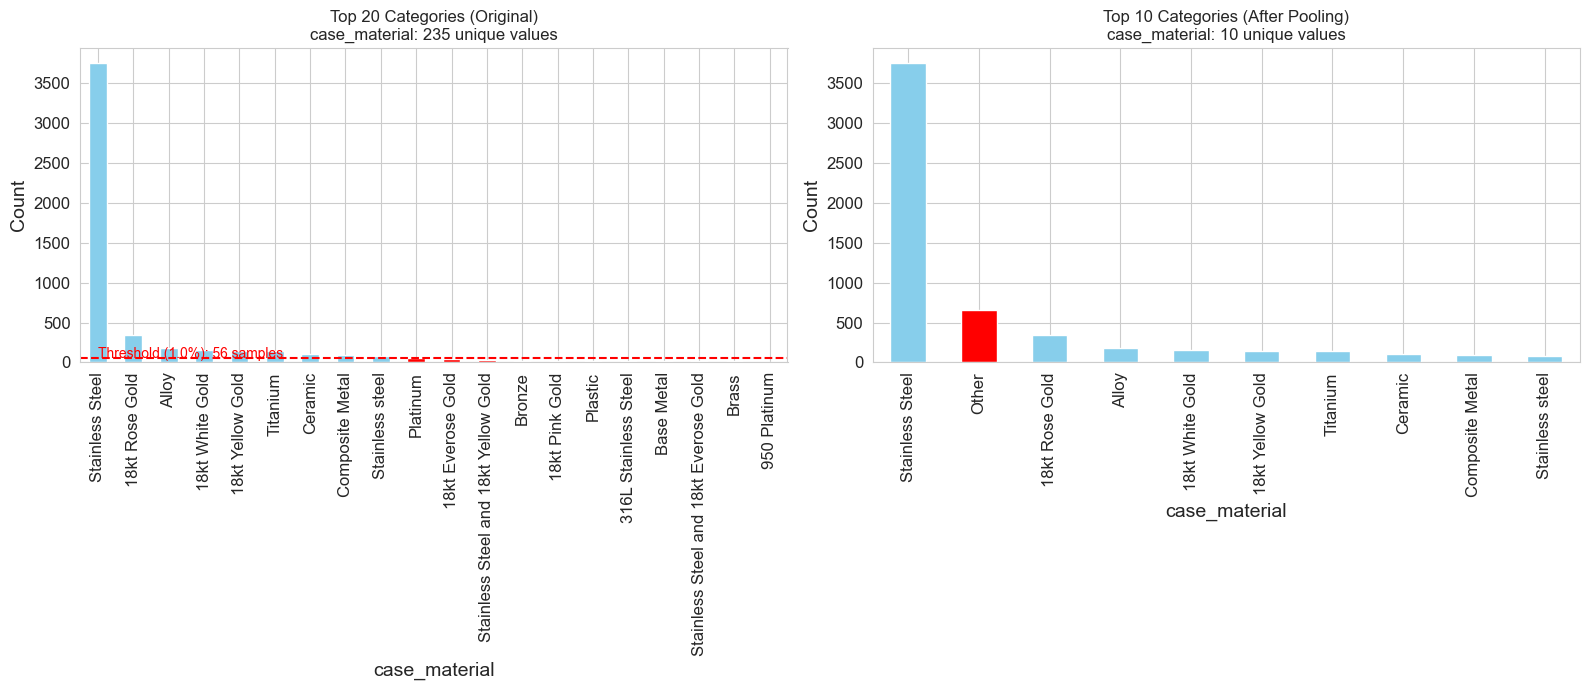

Summary for case_material:
- Original unique values: 235
- Categories below threshold (1.0%): 226 categories (96.2%)
- Samples in rare categories: 662 samples (11.7% of data)
- After pooling: 10 unique values (4.3% of original)
- 'Other' category contains 662 samples (11.7% of data)

Analyzing column: band_material


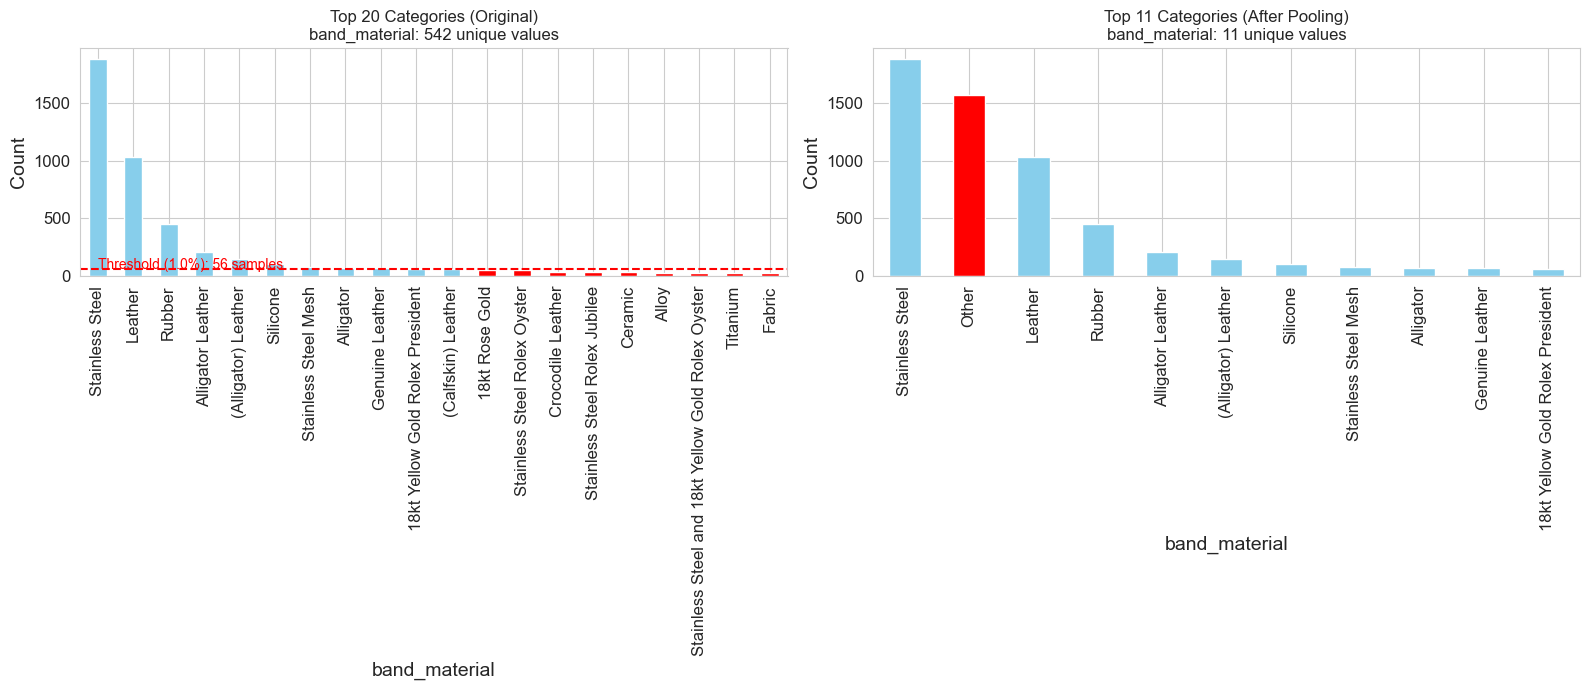

Summary for band_material:
- Original unique values: 542
- Categories below threshold (1.0%): 531 categories (98.0%)
- Samples in rare categories: 1509 samples (26.6% of data)
- After pooling: 11 unique values (2.0% of original)
- 'Other' category contains 1565 samples (27.6% of data)

Analyzing column: case_back


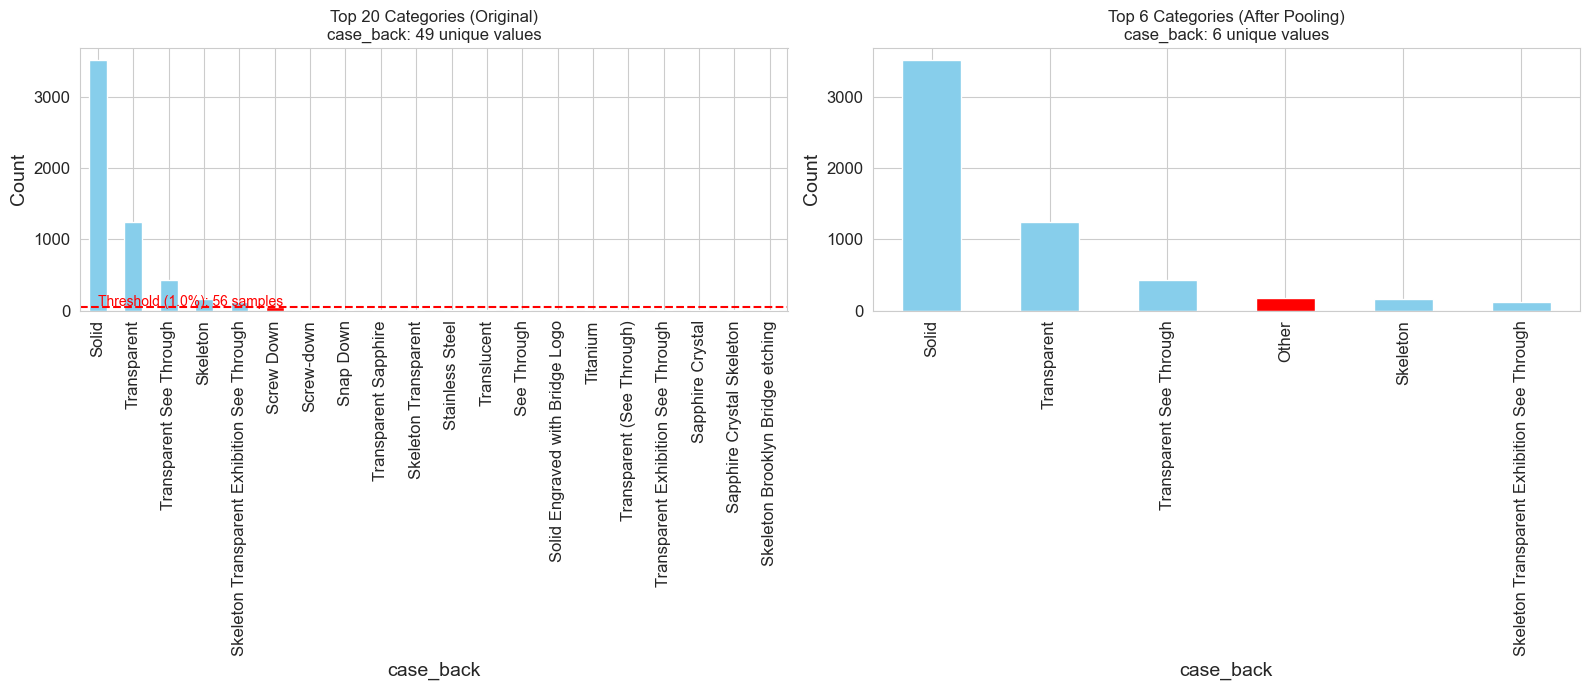

Summary for case_back:
- Original unique values: 49
- Categories below threshold (1.0%): 44 categories (89.8%)
- Samples in rare categories: 172 samples (3.0% of data)
- After pooling: 6 unique values (12.2% of original)
- 'Other' category contains 172 samples (3.0% of data)

Analyzing column: bezel_material


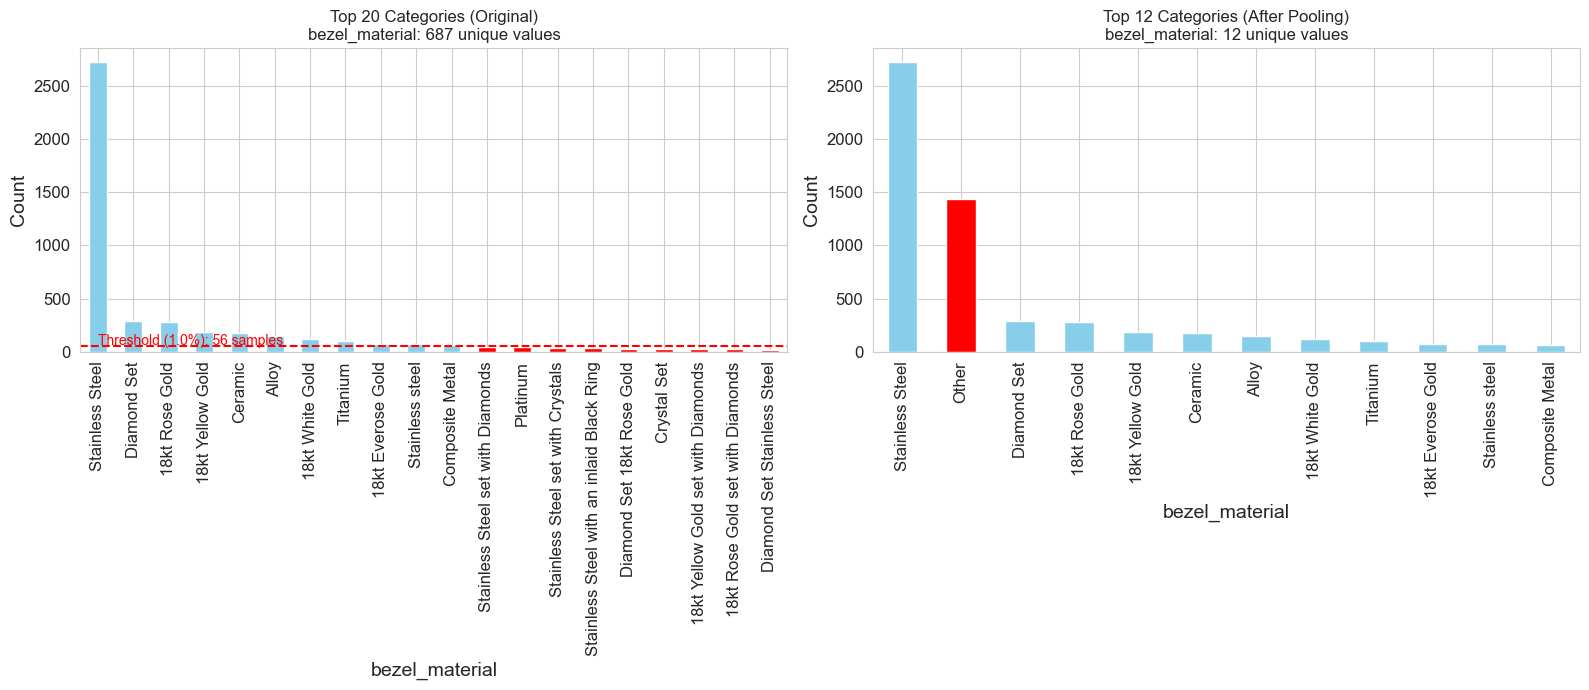

Summary for bezel_material:
- Original unique values: 687
- Categories below threshold (1.0%): 676 categories (98.4%)
- Samples in rare categories: 1438 samples (25.4% of data)
- After pooling: 12 unique values (1.7% of original)
- 'Other' category contains 1438 samples (25.4% of data)

Analyzing column: brand


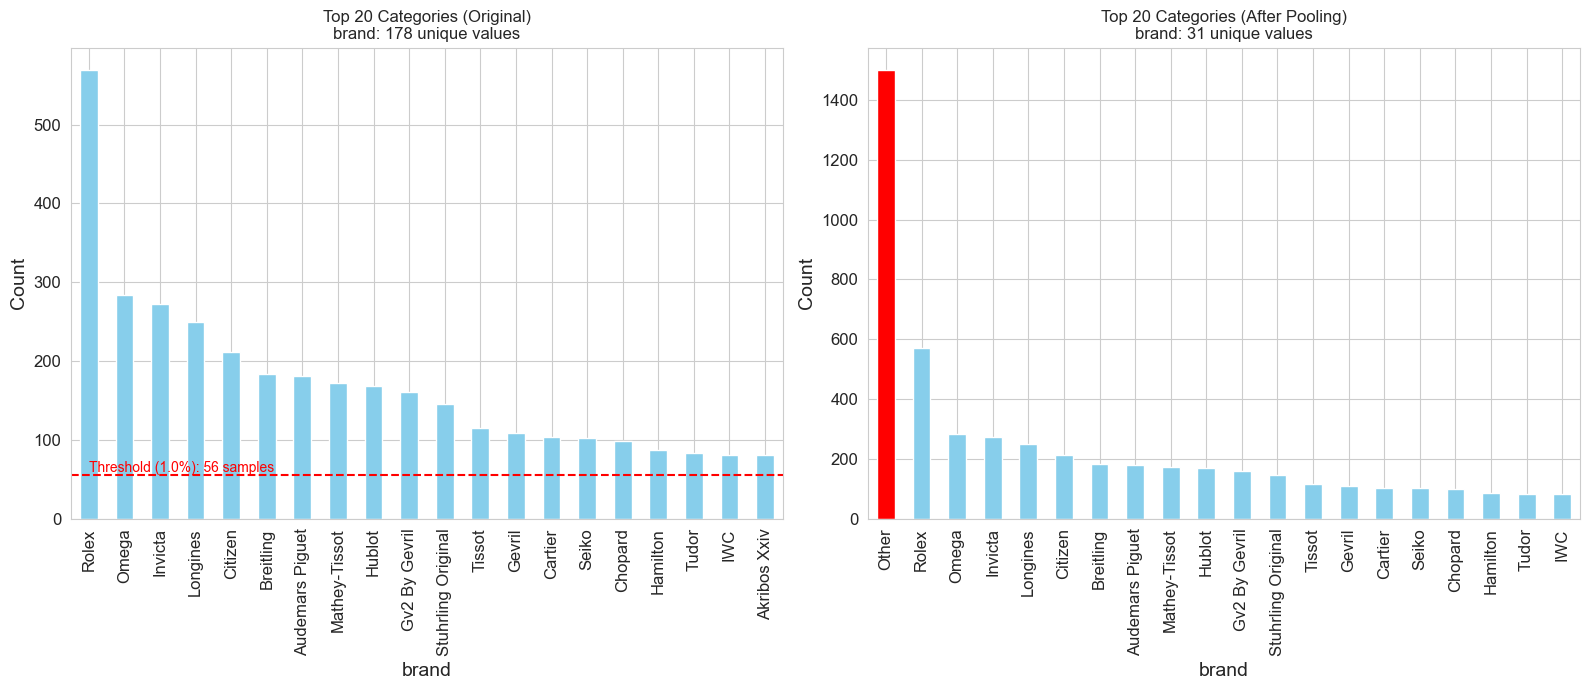

Summary for brand:
- Original unique values: 178
- Categories below threshold (1.0%): 148 categories (83.1%)
- Samples in rare categories: 1499 samples (26.5% of data)
- After pooling: 31 unique values (17.4% of original)
- 'Other' category contains 1499 samples (26.5% of data)

Analyzing column: crystal


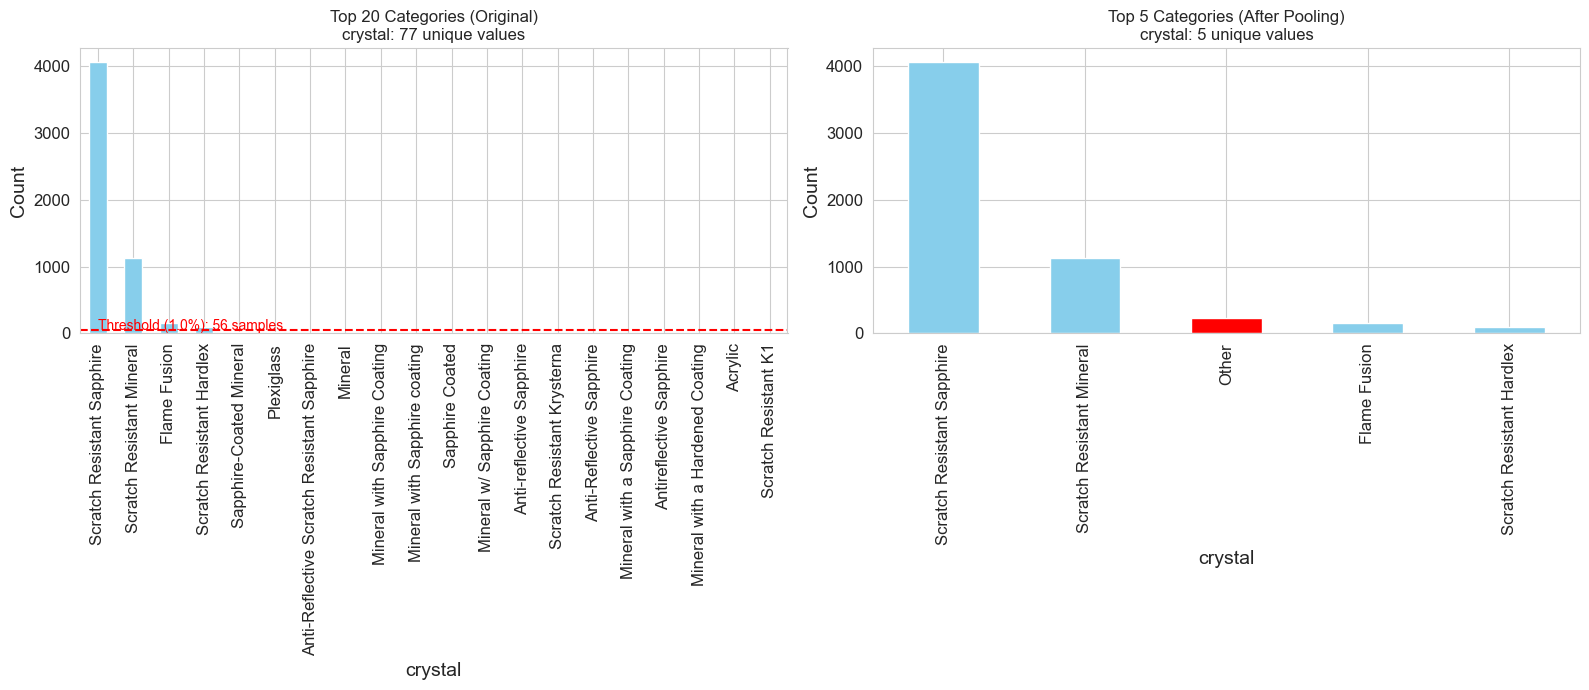

Summary for crystal:
- Original unique values: 77
- Categories below threshold (1.0%): 73 categories (94.8%)
- Samples in rare categories: 227 samples (4.0% of data)
- After pooling: 5 unique values (6.5% of original)
- 'Other' category contains 227 samples (4.0% of data)

Analyzing column: hands


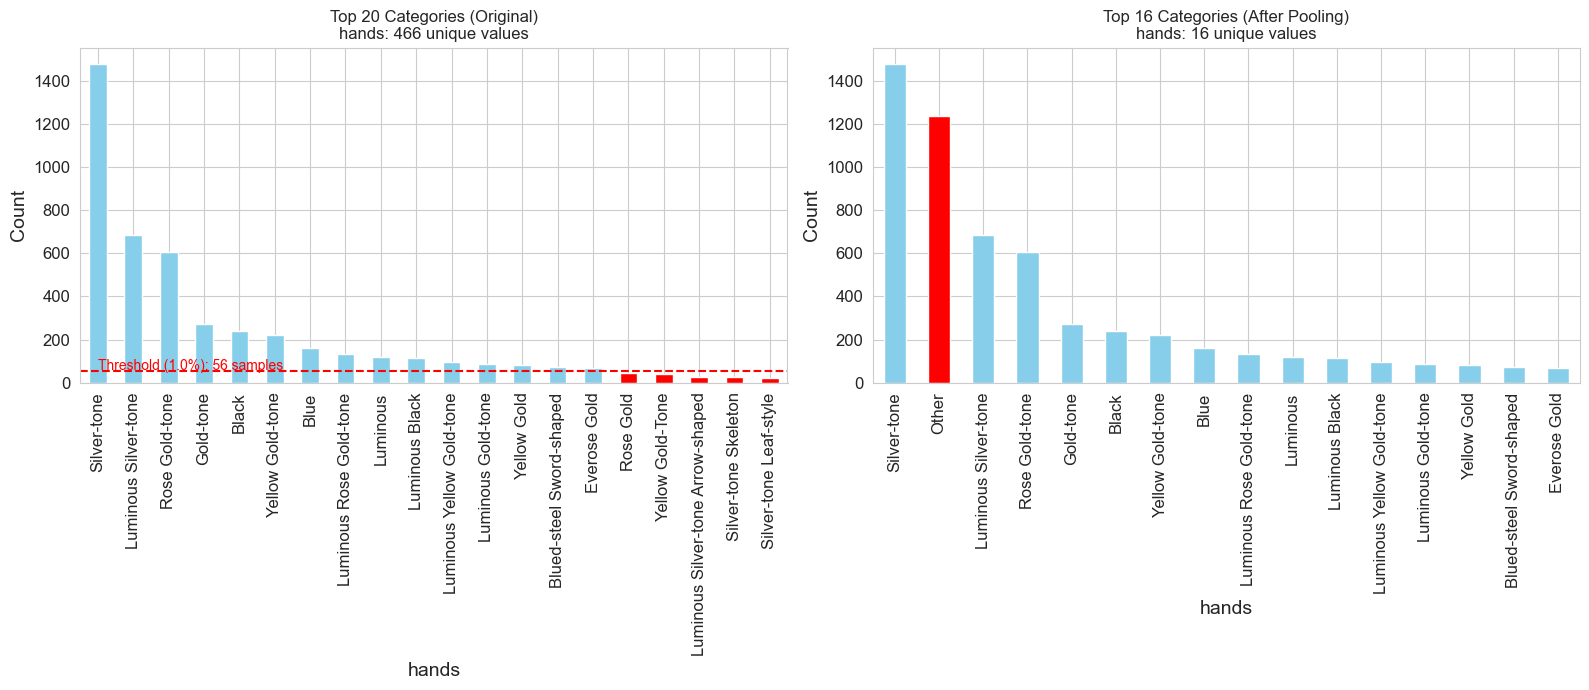

Summary for hands:
- Original unique values: 466
- Categories below threshold (1.0%): 451 categories (96.8%)
- Samples in rare categories: 1235 samples (21.8% of data)
- After pooling: 16 unique values (3.4% of original)
- 'Other' category contains 1235 samples (21.8% of data)

Analyzing column: dial_markers


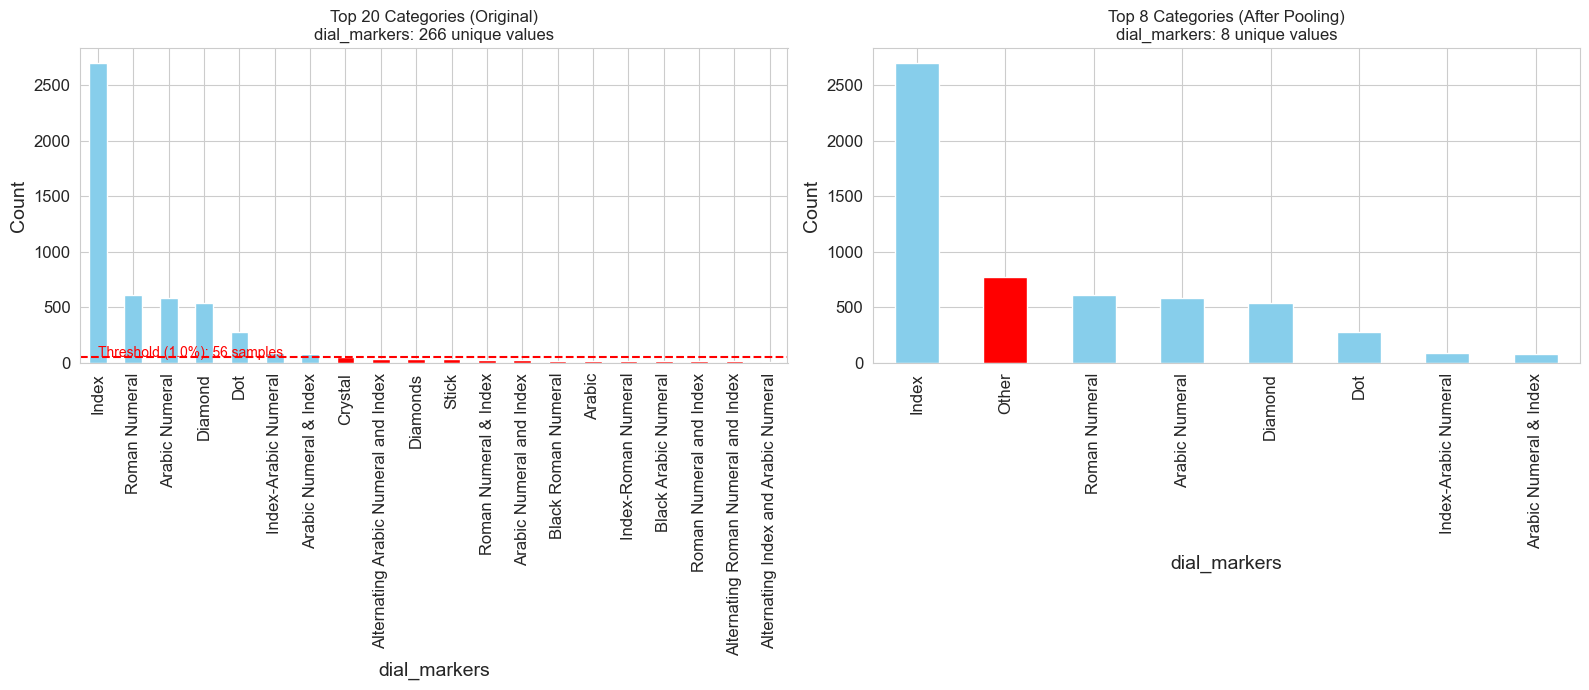

Summary for dial_markers:
- Original unique values: 266
- Categories below threshold (1.0%): 259 categories (97.4%)
- Samples in rare categories: 775 samples (13.7% of data)
- After pooling: 8 unique values (3.0% of original)
- 'Other' category contains 775 samples (13.7% of data)


In [147]:
# Print which columns are considered high cardinality
print(f"High cardinality columns (> 10 unique values): {high_card_cols}")

# Visualize each high cardinality column
for col in high_card_cols:
    print(f"\n{'='*80}\nAnalyzing column: {col}\n{'='*80}")
    visualize_category_pooling(df, col, threshold=0.01)

Applying PCA for dimensionality reduction...
Original dimensions: 24
Reduced dimensions with PCA: 12
Explained variance ratio: [0.40216939 0.19892263 0.12517972 0.08898296 0.03644619 0.02388397
 0.02045894 0.01742123 0.01480097 0.01018985 0.00950056 0.00856678]
Total explained variance: 0.9565


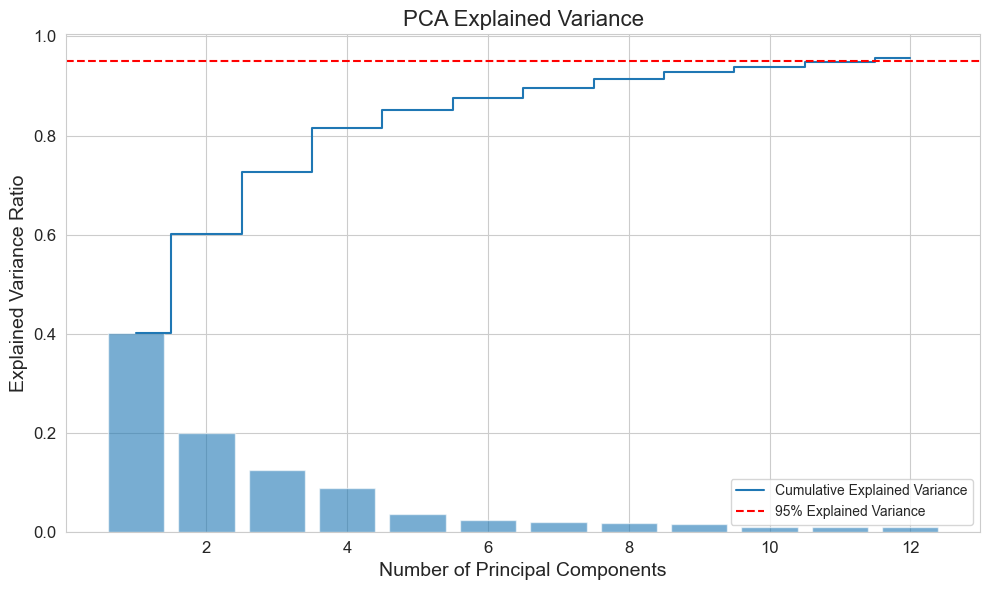

In [148]:
# Apply PCA for dimensionality reduction
# This will help with visualization and improve performance of clustering algorithms
from sklearn.decomposition import PCA

print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=0.95)  # Keep 95% of variance
df_pca = pd.DataFrame(pca.fit_transform(df_gmm))

print(f"Original dimensions: {df_gmm.shape[1]}")
print(f"Reduced dimensions with PCA: {df_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Visualize the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.6)
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
#
# # Nếu bạn có `df_pca` và `kproto_clusters`
# plt.figure(figsize=(10, 6))
# plt.scatter(df_pca[0], df_pca[1], c=kproto_clusters, cmap='tab10', alpha=0.7)
# plt.title('PCA Visualization of Clusters (K-Prototypes)')
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.colorbar(label='Cluster')
# plt.show()


Đang tìm số cụm tối ưu với covariance_type = 'full'...
n_components = 2, BIC = 26486.71, Silhouette = 0.157
n_components = 3, BIC = -10544.90, Silhouette = 0.124
n_components = 4, BIC = -64467.81, Silhouette = 0.140
n_components = 5, BIC = -81516.92, Silhouette = 0.107
n_components = 6, BIC = -97504.46, Silhouette = 0.070
n_components = 7, BIC = -92679.48, Silhouette = 0.061
n_components = 8, BIC = -115179.36, Silhouette = 0.145
n_components = 9, BIC = -119832.98, Silhouette = 0.119

Số cụm tối ưu dựa trên BIC: 9
Giá trị BIC tốt nhất: -119832.98


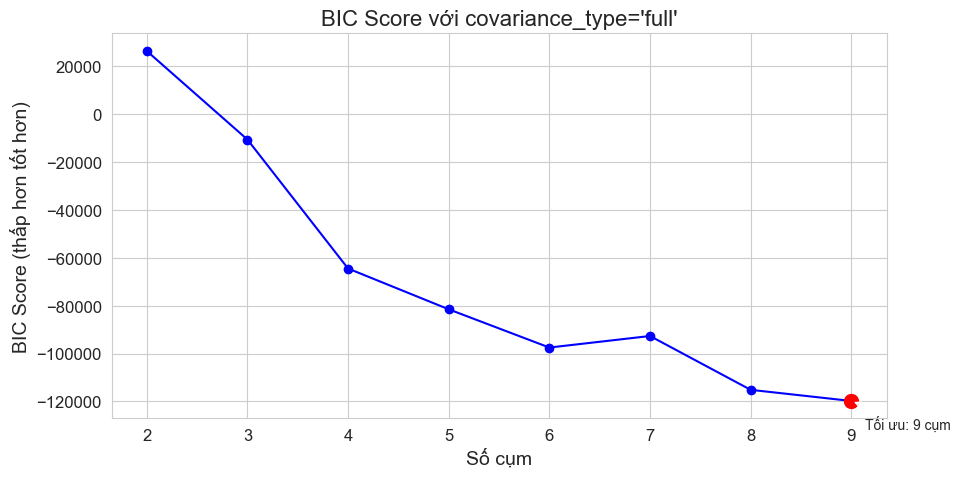

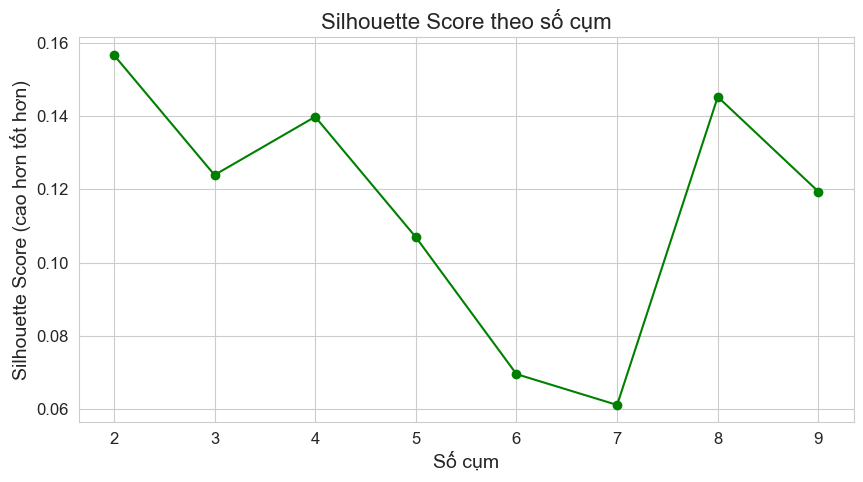

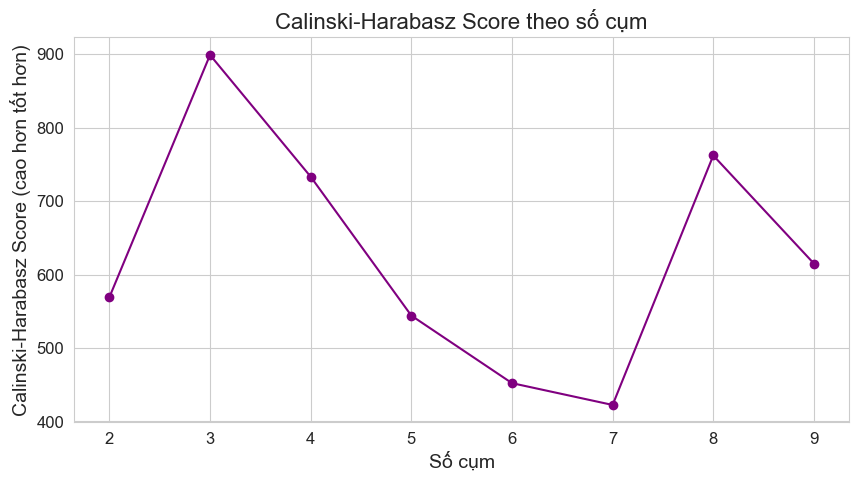

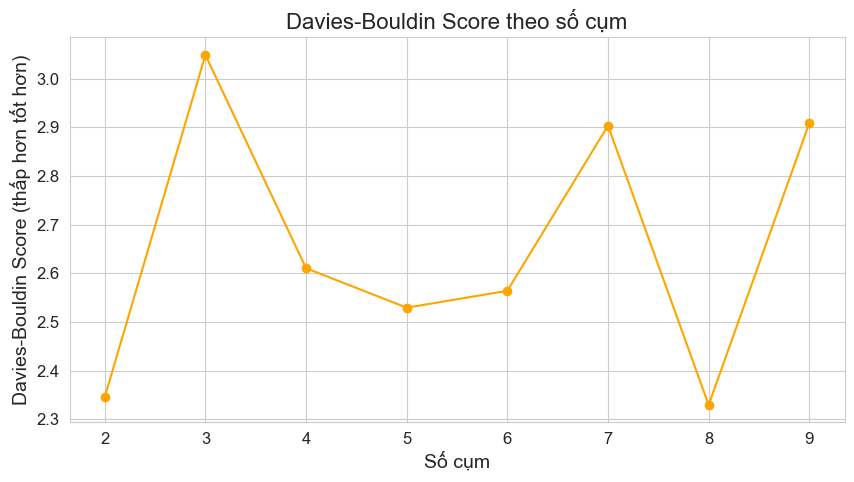

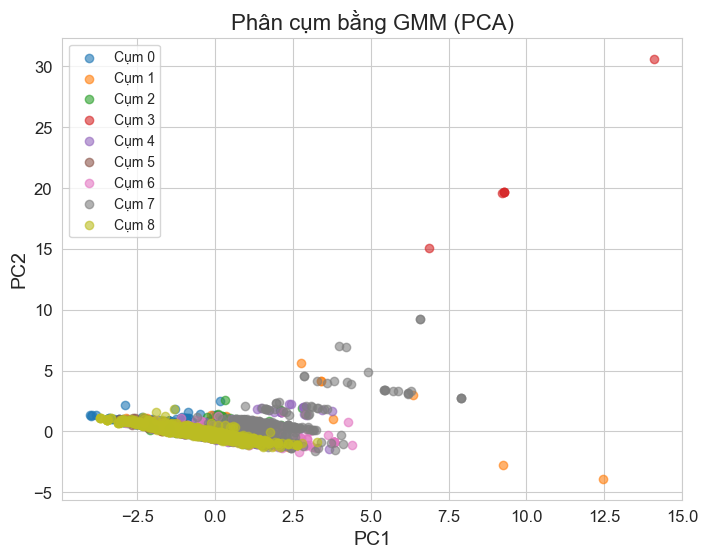


--- Điểm đánh giá theo từng số cụm ---
   Số cụm            BIC  Silhouette  Calinski-Harabasz  Davies-Bouldin
0       2   26486.709473    0.156635         569.037068        2.345806
1       3  -10544.896335    0.123884         898.777334        3.048887
2       4  -64467.809572    0.139766         733.088561        2.610597
3       5  -81516.919647    0.106929         544.078429        2.529468
4       6  -97504.458902    0.069560         452.151962        2.564139
5       7  -92679.481139    0.061145         422.469656        2.903593
6       8 -115179.357783    0.145202         761.968094        2.329541
7       9 -119832.978228    0.119346         614.899416        2.908938


In [149]:

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Giả định dữ liệu đã chuẩn bị ---
# df_original: dataframe gốc
# df_pca: dữ liệu sau PCA (2 hoặc nhiều chiều)

covariance_type = 'full'
n_components_range = range(2, 10)

bic_scores = []
silhouette_scores = []
ch_scores = []
db_scores = []
models = []

print(f"Đang tìm số cụm tối ưu với covariance_type = '{covariance_type}'...")

for n_components in n_components_range:
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        random_state=42,
        max_iter=100,
        n_init=3
    )
    gmm.fit(df_pca)
    labels = gmm.predict(df_pca)
    
    # Tính các chỉ số đánh giá
    bic = gmm.bic(df_pca)
    bic_scores.append(bic)
    models.append(gmm)
    
    silhouette_scores.append(silhouette_score(df_pca, labels))
    ch_scores.append(calinski_harabasz_score(df_pca, labels))
    db_scores.append(davies_bouldin_score(df_pca, labels))

    print(f"n_components = {n_components}, BIC = {bic:.2f}, Silhouette = {silhouette_scores[-1]:.3f}")

# --- Chọn mô hình tối ưu ---
optimal_idx = np.argmin(bic_scores)
optimal_n_components = n_components_range[optimal_idx]
best_gmm = models[optimal_idx]
best_labels = best_gmm.predict(df_pca)

print(f"\nSố cụm tối ưu dựa trên BIC: {optimal_n_components}")
print(f"Giá trị BIC tốt nhất: {bic_scores[optimal_idx]:.2f}")

# --- Gán nhãn cụm vào dataframe ---
df_original['gmm_cluster'] = best_labels

# --- Vẽ biểu đồ BIC ---
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, 'o-', label='BIC', color='blue')
plt.plot(optimal_n_components, bic_scores[optimal_idx], 'ro', markersize=10)
plt.annotate(f'Tối ưu: {optimal_n_components} cụm',
             (optimal_n_components, bic_scores[optimal_idx]),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->'))
plt.title(f"BIC Score với covariance_type='{covariance_type}'")
plt.xlabel("Số cụm")
plt.ylabel("BIC Score (thấp hơn tốt hơn)")
plt.grid(True)
plt.show()

# --- Vẽ biểu đồ Silhouette Score ---
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, silhouette_scores, 'o-', color='green')
plt.title("Silhouette Score theo số cụm")
plt.xlabel("Số cụm")
plt.ylabel("Silhouette Score (cao hơn tốt hơn)")
plt.grid(True)
plt.show()


# --- Vẽ biểu đồ Calinski-Harabasz Score ---
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, ch_scores, 'o-', color='purple')
plt.title("Calinski-Harabasz Score theo số cụm")
plt.xlabel("Số cụm")
plt.ylabel("Calinski-Harabasz Score (cao hơn tốt hơn)")
plt.grid(True)
plt.show()

# --- Vẽ biểu đồ Davies-Bouldin Score ---
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, db_scores, 'o-', color='orange')
plt.title("Davies-Bouldin Score theo số cụm")
plt.xlabel("Số cụm")
plt.ylabel("Davies-Bouldin Score (thấp hơn tốt hơn)")
plt.grid(True)
plt.show()


# --- PCA Scatter Plot với nhãn cụm ---
if df_pca.shape[1] >= 2:
    plt.figure(figsize=(8, 6))
    for cluster in np.unique(best_labels):
        idx = best_labels == cluster
        plt.scatter(df_pca.iloc[idx, 0], df_pca.iloc[idx, 1], label=f'Cụm {cluster}', alpha=0.6)
    plt.title("Phân cụm bằng GMM (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()



# --- In thêm thông tin chấm điểm ---
print("\n--- Điểm đánh giá theo từng số cụm ---")
results = pd.DataFrame({
    "Số cụm": n_components_range,
    "BIC": bic_scores,
    "Silhouette": silhouette_scores,
    "Calinski-Harabasz": ch_scores,
    "Davies-Bouldin": db_scores
})
print(results)






=== PHÂN TÍCH PHÂN PHỐI CỦA CÁC CỤM ===
gmm_cluster
0    1080
1     812
2     482
3       6
4    1623
5     769
6     508
7     385
Name: count, dtype: int64

Phần trăm phân phối:
gmm_cluster
0    19.064431
1    14.333628
2     8.508385
3     0.105914
4    28.649603
5    13.574581
6     8.967343
7     6.796117
Name: count, dtype: float64


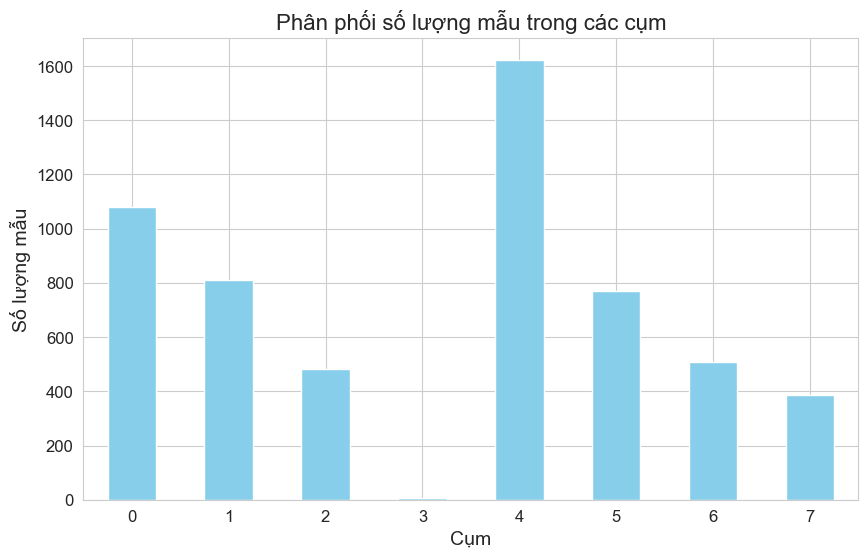

In [150]:
best_gmm_component = 8

best_gmm = GaussianMixture(
        n_components=best_gmm_component,
        covariance_type=covariance_type,
        random_state=42,
        max_iter=100,
        n_init=3
    )

best_gmm.fit(df_pca)

# Gán nhãn cụm
df_original['gmm_cluster'] = best_gmm.predict(df_pca)


# Phân tích kết quả phân cụm
print("\n=== PHÂN TÍCH PHÂN PHỐI CỦA CÁC CỤM ===")
cluster_counts = df_original['gmm_cluster'].value_counts().sort_index()
print(cluster_counts)
print("\nPhần trăm phân phối:")
print(100 * cluster_counts / len(df))

# Trực quan hóa phân phối cụm
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Phân phối số lượng mẫu trong các cụm')
plt.xlabel('Cụm')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=0)
plt.show()

# 5. Trực quan hóa kết quả phân cụm GMM

Chúng ta sẽ giảm chiều dữ liệu xuống 2 thành phần chính bằng PCA và trực quan hóa các cụm GMM trên không gian này để so sánh với Agglomerative Clustering.

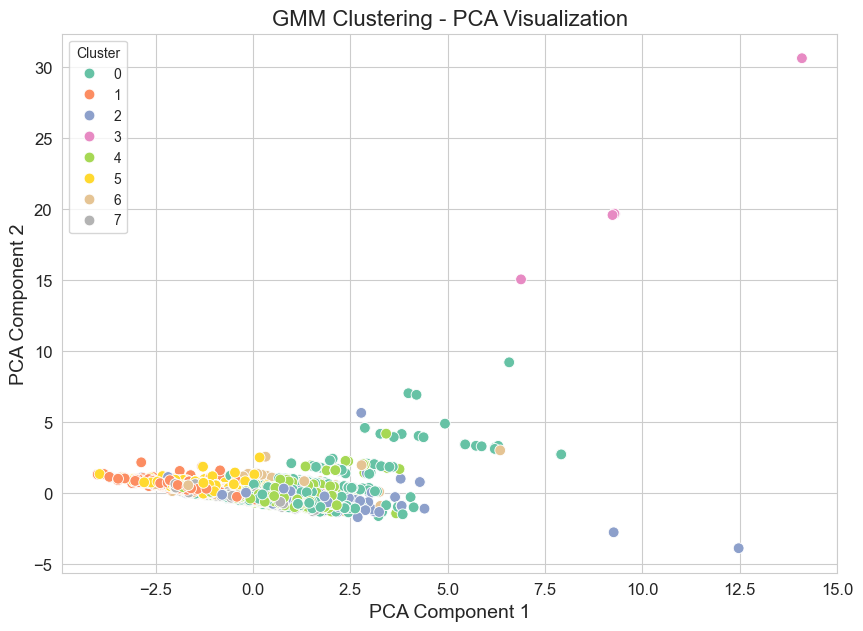

Phương sai giải thích bởi 2 thành phần chính: 60.11%
PCA1: 40.22%, PCA2: 19.89%


In [151]:
# Giảm chiều dữ liệu xuống 2 thành phần chính để trực quan hóa
from sklearn.decomposition import PCA

pca_vis = PCA(n_components=2)
pca_2d = pca_vis.fit_transform(df_gmm)
df_original['pca_1'] = pca_2d[:, 0]
df_original['pca_2'] = pca_2d[:, 1]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_original, x='pca_1', y='pca_2', hue='gmm_cluster', palette='Set2', s=60)
plt.title('GMM Clustering - PCA Visualization', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

explained_var = pca_vis.explained_variance_ratio_
print(f"Phương sai giải thích bởi 2 thành phần chính: {sum(explained_var)*100:.2f}%")
print(f"PCA1: {explained_var[0]*100:.2f}%, PCA2: {explained_var[1]*100:.2f}%")

In [152]:
# # Lọc bỏ cụm nhiễu (ví dụ cụm 2)
# df_cleaned = df_original[df_original['gmm_cluster'] != 3].copy()

# df_original = df_cleaned.copy()

# # Kiểm tra lại
# print("Kích thước dữ liệu sau khi loại cụm nhiễu:", df_cleaned.shape)


## 6. Phân tích đặc điểm của các cụm GMM

### 6.1. Phân tích đặc trưng số

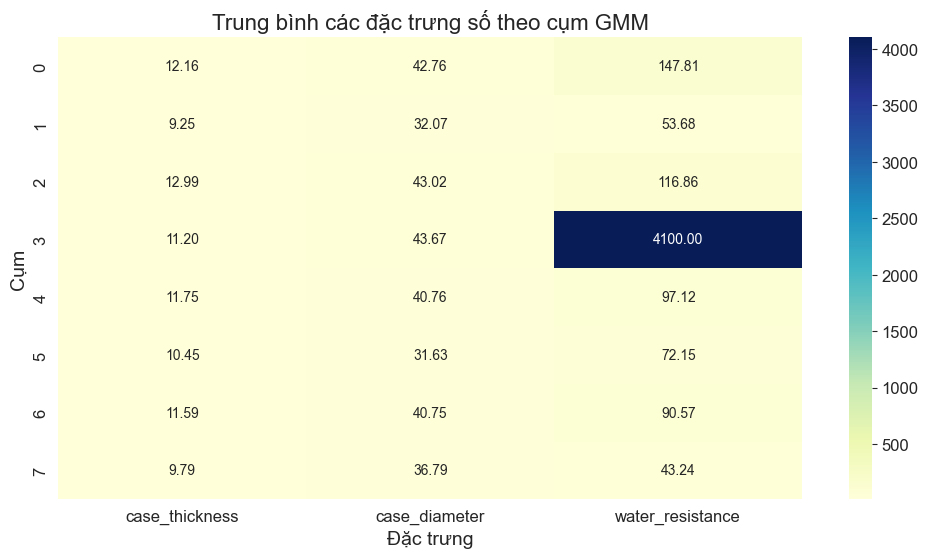

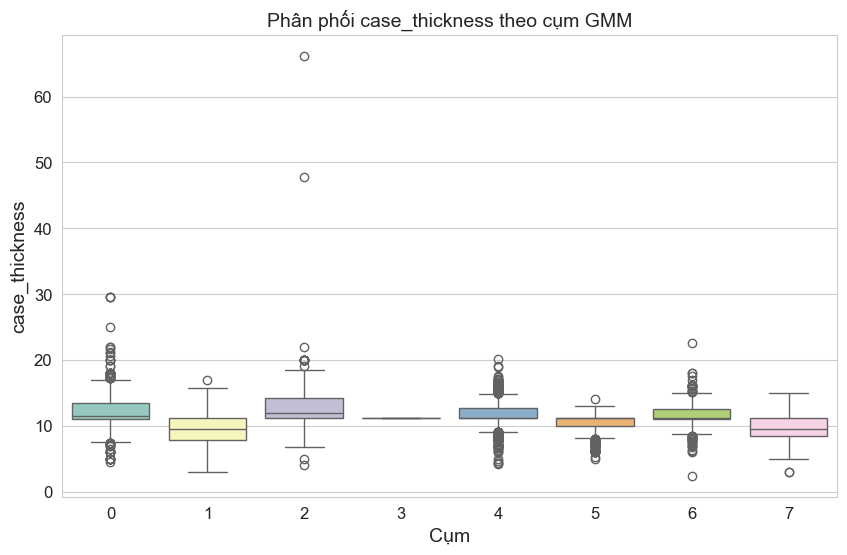

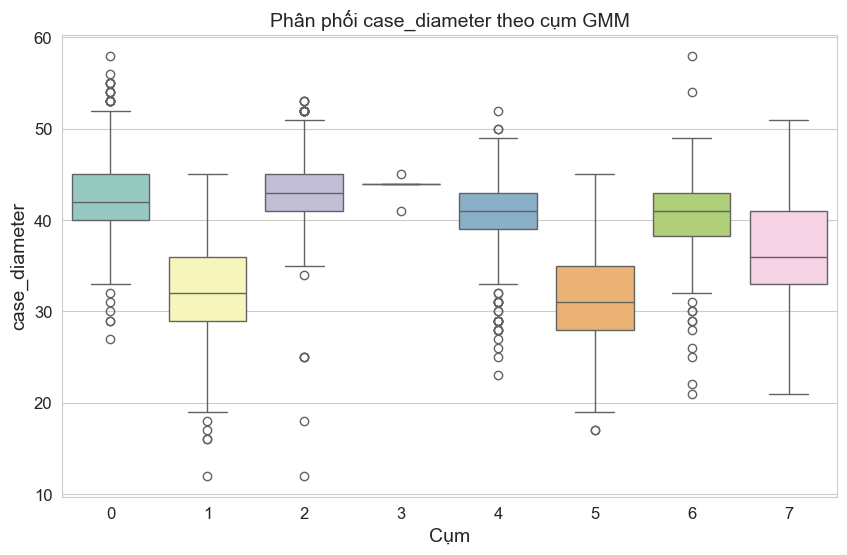

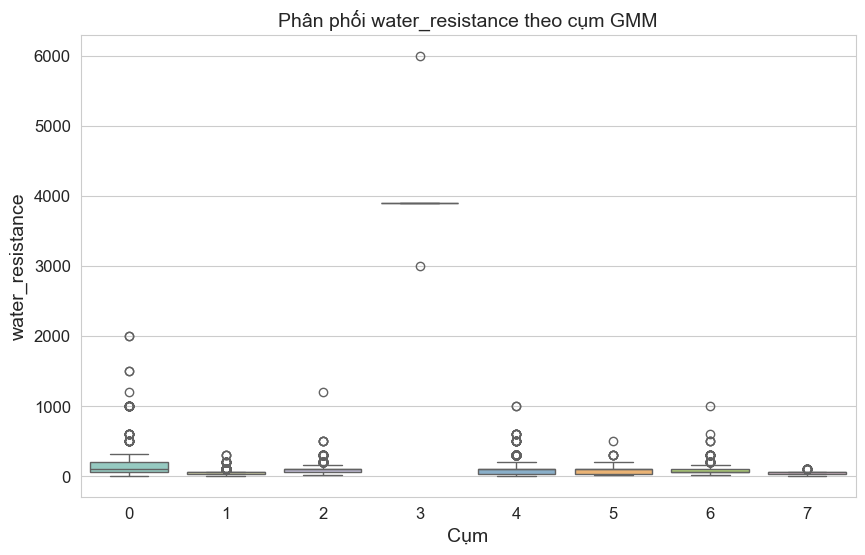

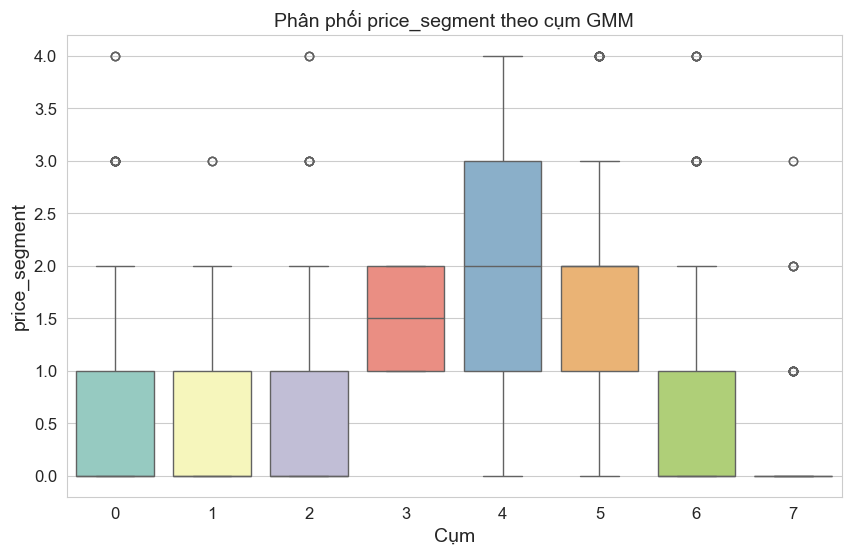

In [153]:
# Trung bình các đặc trưng số theo cụm GMM
num_cols = ['case_thickness', 'case_diameter', 'water_resistance']
cluster_means = df_original.groupby('gmm_cluster')[num_cols].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Trung bình các đặc trưng số theo cụm GMM', fontsize=16)
plt.ylabel('Cụm')
plt.xlabel('Đặc trưng')
plt.show()

# Boxplot cho từng đặc trưng số và price_segment theo cụm
for col in num_cols + ['price_segment']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_original, x='gmm_cluster', y=col, palette='Set3')
    plt.title(f'Phân phối {col} theo cụm GMM', fontsize=14)
    plt.xlabel('Cụm')
    plt.ylabel(col)
    plt.show()

### 6.2. Phân tích đặc trưng phân loại theo cụm GMM

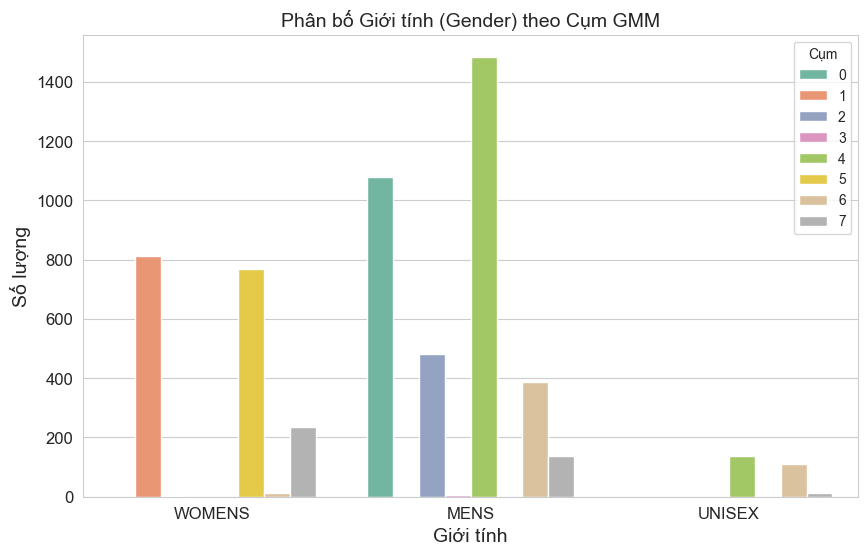

<Figure size 1000x600 with 0 Axes>

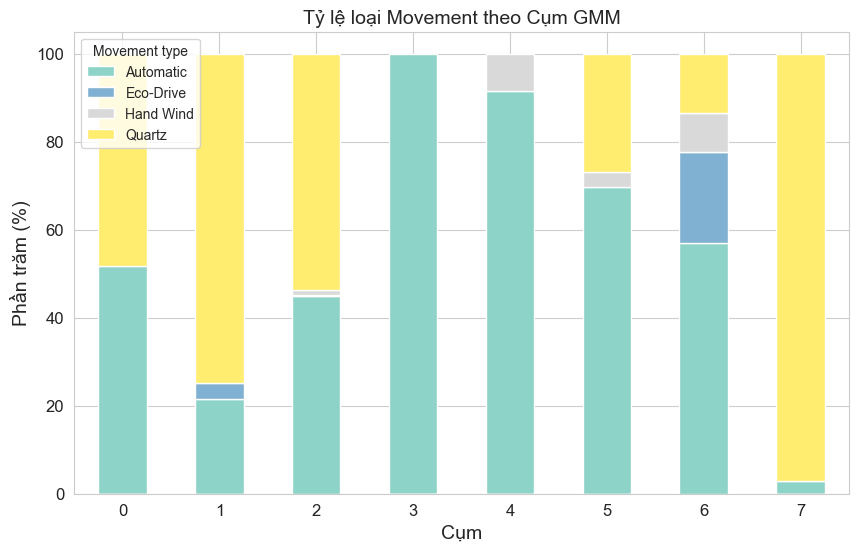

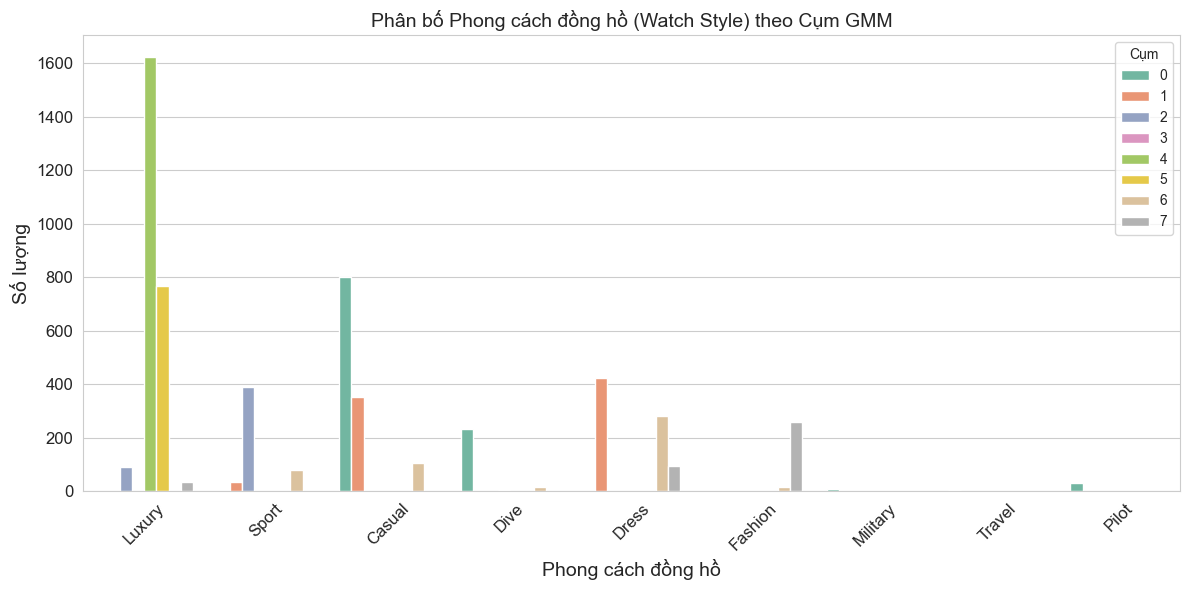

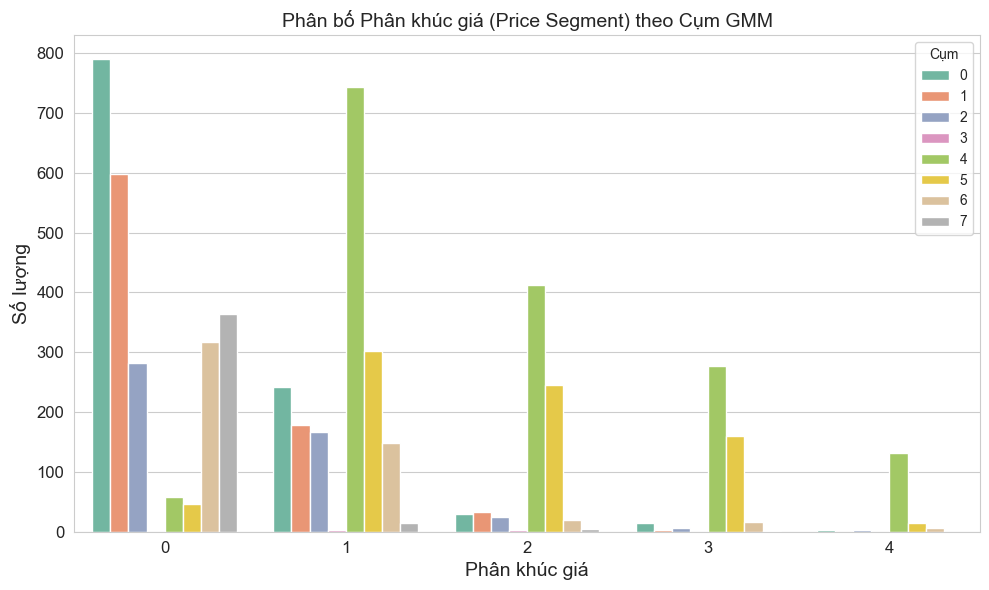

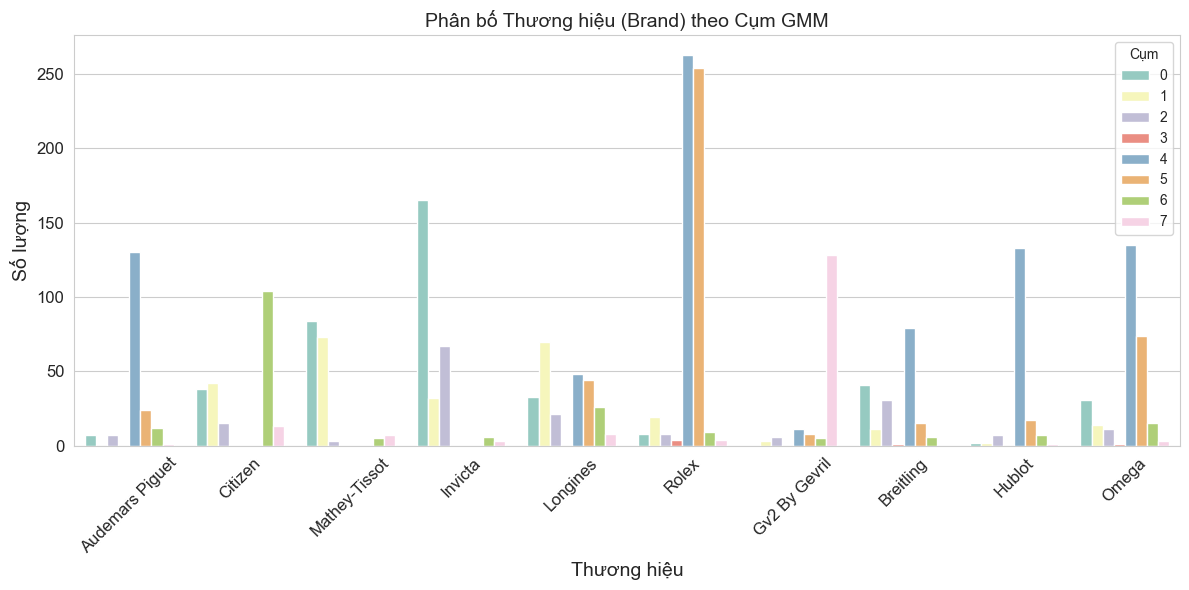

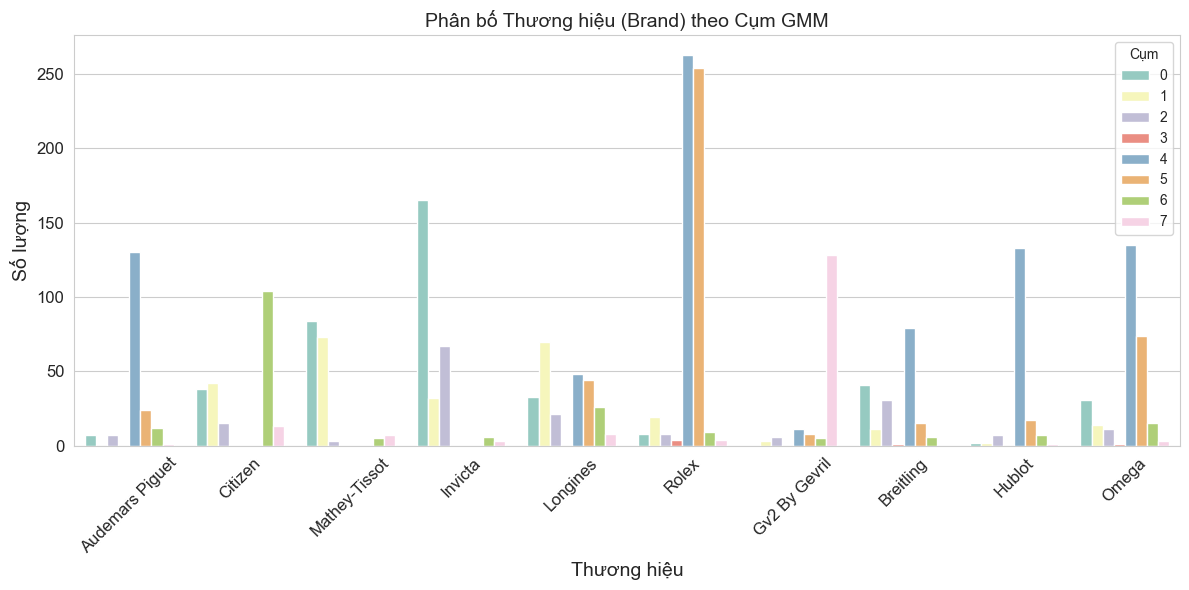

In [154]:
# Gender distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='gmm_cluster', data=df_original, palette='Set2')
plt.title('Phân bố Giới tính (Gender) theo Cụm GMM', fontsize=14)
plt.xlabel('Giới tính')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.show()

# Movement type distribution by cluster
plt.figure(figsize=(10, 6))
movement_counts = df_original.groupby(['gmm_cluster', 'movement']).size().unstack()
movement_proportions = movement_counts.div(movement_counts.sum(axis=1), axis=0) * 100
movement_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
plt.title('Tỷ lệ loại Movement theo Cụm GMM', fontsize=14)
plt.xlabel('Cụm')
plt.ylabel('Phần trăm (%)')
plt.legend(title='Movement type')
plt.xticks(rotation=0)
plt.show()

# Watch style distribution by cluster
plt.figure(figsize=(12, 6))
sns.countplot(x='watch_style', hue='gmm_cluster', data=df_original, palette='Set2')
plt.title('Phân bố Phong cách đồng hồ (Watch Style) theo Cụm GMM', fontsize=14)
plt.xlabel('Phong cách đồng hồ')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# price_segment distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='price_segment', hue='gmm_cluster', data=df_original, palette='Set2')
plt.title('Phân bố Phân khúc giá (Price Segment) theo Cụm GMM', fontsize=14)
plt.xlabel('Phân khúc giá')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
top_brands = df_original['brand'].value_counts().nlargest(10).index  # Top 10 thương hiệu phổ biến
sns.countplot(x='brand', hue='gmm_cluster', data=df_original[df_original['brand'].isin(top_brands)], palette='Set3')
plt.title('Phân bố Thương hiệu (Brand) theo Cụm GMM', fontsize=14)
plt.xlabel('Thương hiệu')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
top_brands = df_original['brand'].value_counts().nlargest(10).index  # Top 10 thương hiệu phổ biến
sns.countplot(x='brand', hue='gmm_cluster', data=df_original[df_original['brand'].isin(top_brands)], palette='Set3')
plt.title('Phân bố Thương hiệu (Brand) theo Cụm GMM', fontsize=14)
plt.xlabel('Thương hiệu')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# plt.figure(figsize=(10, 6))
# sns.boxplot(x='gmm_cluster', y='price', data=df_original, palette='Set2')
# plt.title('Phân bố Giá thực tế theo Cụm GMM', fontsize=14)
# plt.xlabel('Cụm')
# plt.ylabel('Giá (₫)')
# plt.yscale('log')  # nếu giá trải dài nhiều bậc
# plt.tight_layout()
# plt.show()


Tỷ lệ price_segment trong mỗi cụm GMM (%):
price_segment     0     1     2     3    4
gmm_cluster                               
0              73.1  22.4   2.8   1.4  0.3
1              73.6  21.9   4.1   0.4  0.0
2              58.5  34.4   5.2   1.2  0.6
3               0.0  50.0  50.0   0.0  0.0
4               3.6  45.8  25.4  17.1  8.1
5               6.1  39.3  31.9  20.8  2.0
6              62.4  29.1   3.7   3.3  1.4
7              94.5   3.6   1.3   0.5  0.0


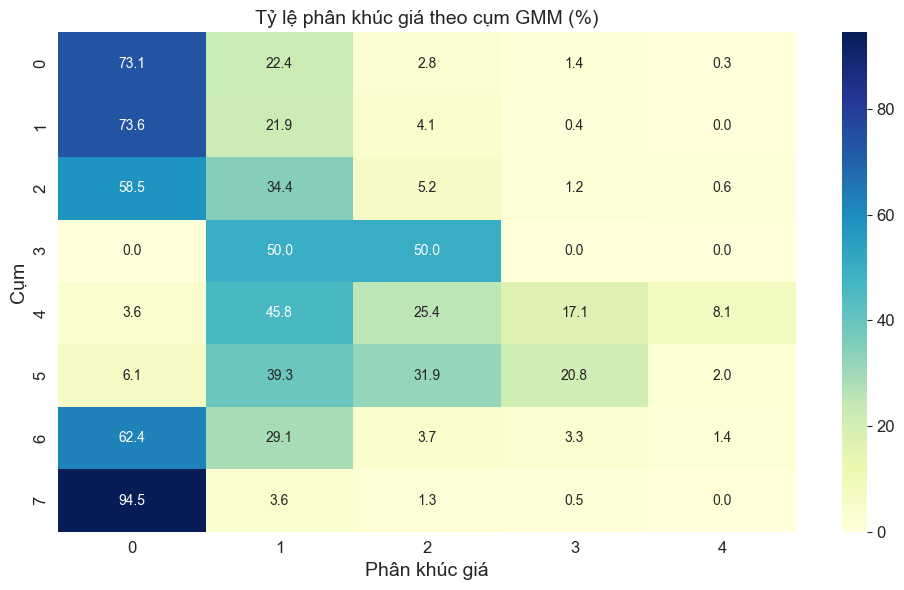

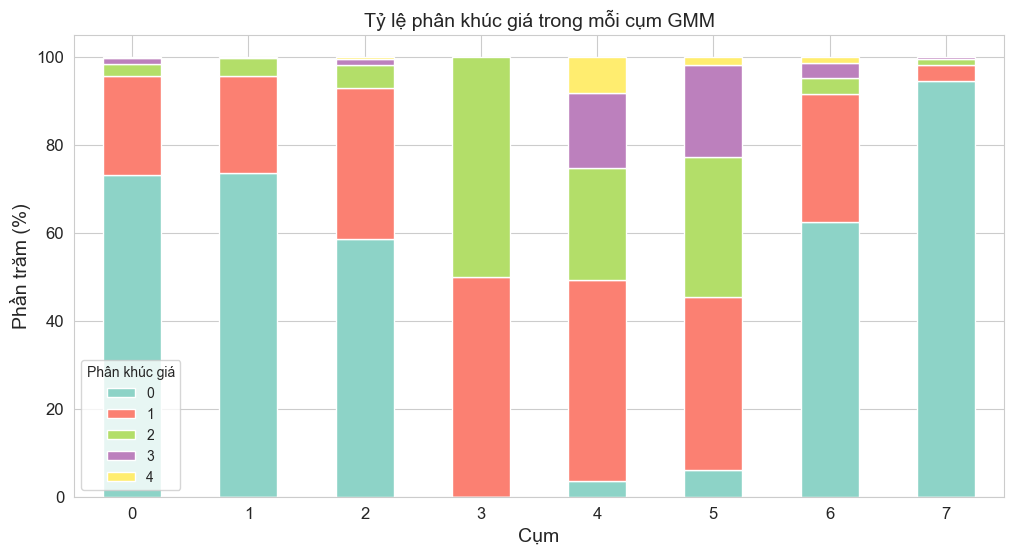

In [155]:
# Tạo bảng tỷ lệ price_segment trong mỗi cụm GMM
segment_cluster_df = pd.crosstab(df_original['gmm_cluster'], df_original['price_segment'], normalize='index') * 100
segment_cluster_df = segment_cluster_df.round(1)

print("Tỷ lệ price_segment trong mỗi cụm GMM (%):")
print(segment_cluster_df)

plt.figure(figsize=(10, 6))
sns.heatmap(segment_cluster_df, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Tỷ lệ phân khúc giá theo cụm GMM (%)', fontsize=14)
plt.xlabel('Phân khúc giá')
plt.ylabel('Cụm')
plt.tight_layout()
plt.show()

# Stacked bar chart cho price_segment theo cụm GMM
segment_counts = df_original.groupby(['gmm_cluster', 'price_segment']).size().unstack()
segment_proportions = segment_counts.div(segment_counts.sum(axis=1), axis=0) * 100
segment_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')
plt.title('Tỷ lệ phân khúc giá trong mỗi cụm GMM', fontsize=14)
plt.xlabel('Cụm')
plt.ylabel('Phần trăm (%)')
plt.legend(title='Phân khúc giá')
plt.xticks(rotation=0)
plt.show()

In [156]:
# Kiểm định chi-square giữa cụm GMM và price_segment
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df_original['gmm_cluster'], df_original['price_segment'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Kết luận: Có mối liên hệ có ý nghĩa thống kê giữa cụm và phân khúc giá" if p < 0.05 else "Kết luận: Không có mối liên hệ có ý nghĩa thống kê")

Chi-square statistic: 3129.90
p-value: 0.0000
Degrees of freedom: 28
Kết luận: Có mối liên hệ có ý nghĩa thống kê giữa cụm và phân khúc giá


### 6.3. Phân tích thương hiệu (Brand) theo cụm GMM

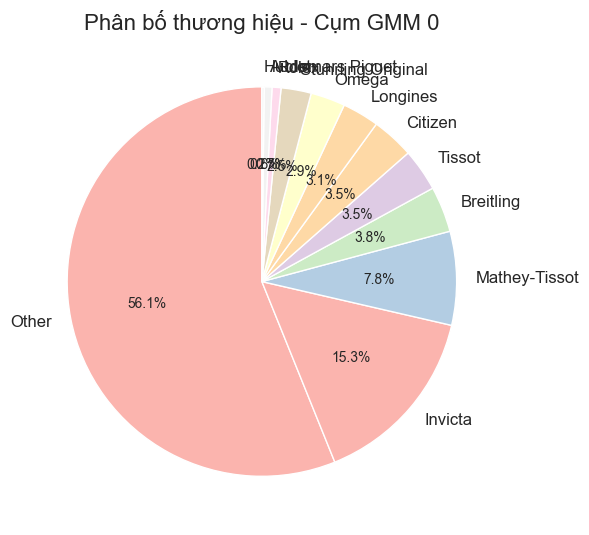

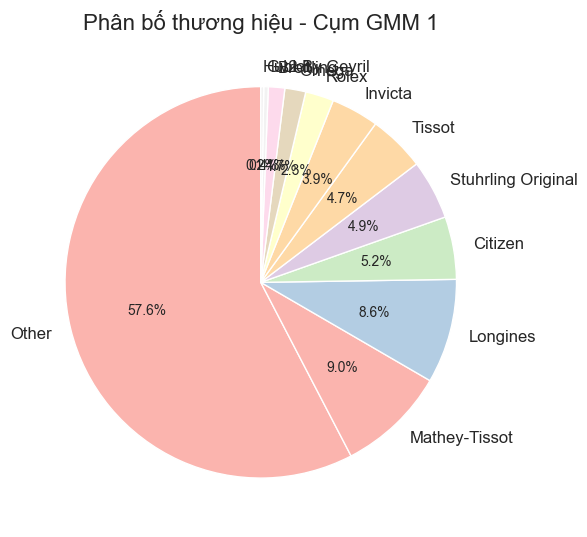

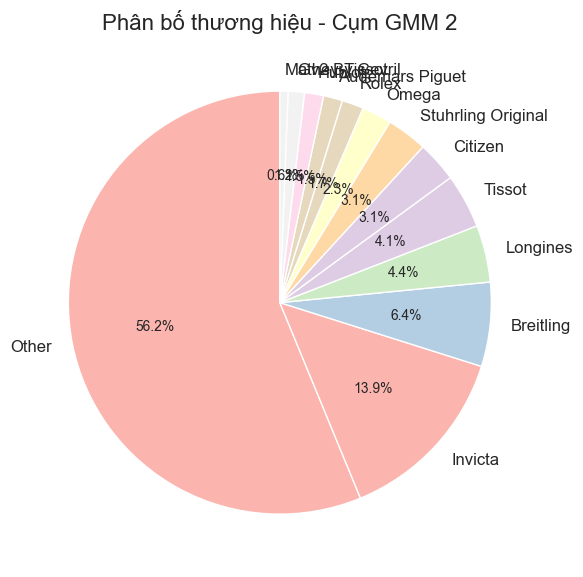

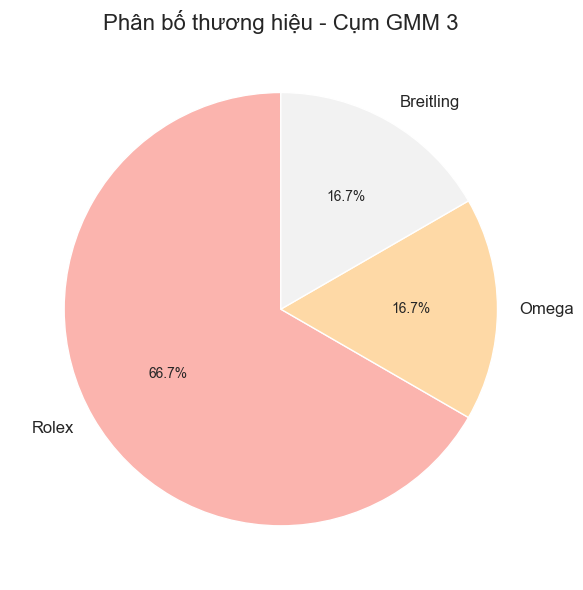

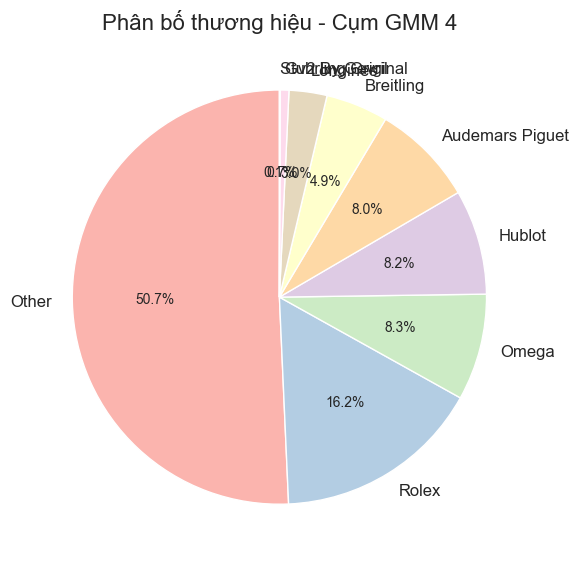

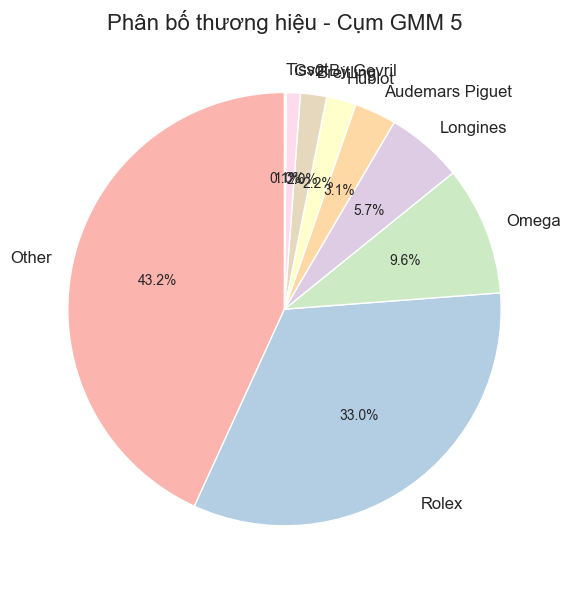

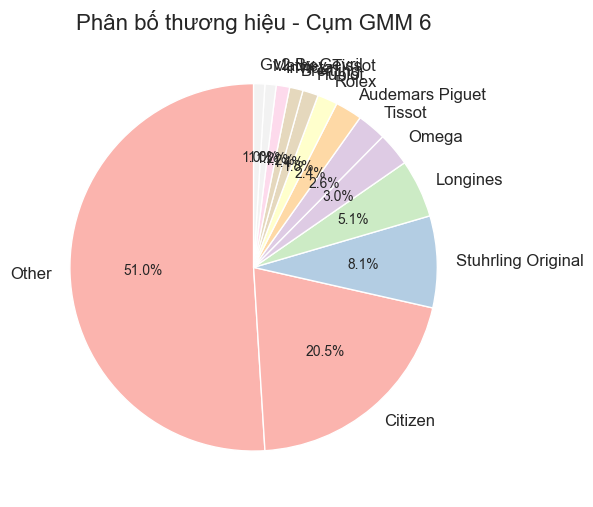

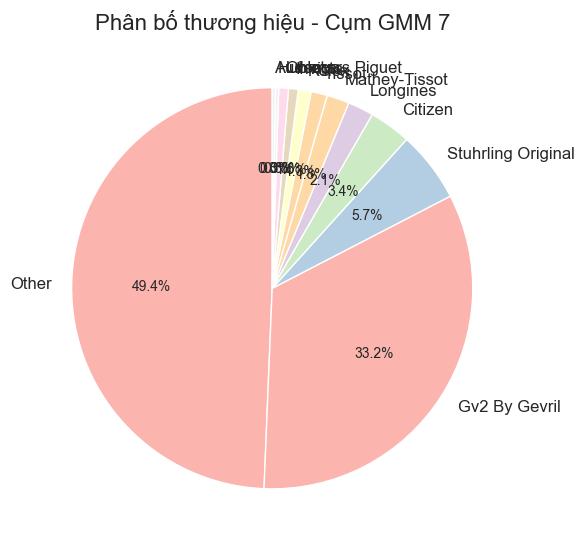

In [157]:
# Gộp thương hiệu hiếm thành 'Other'
def pool_categories(series, threshold=0.02):
    value_counts = series.value_counts(normalize=True)
    rare = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

df_original['brand_pooled'] = pool_categories(df_original['brand'], threshold=0.02)

for cluster_id in sorted(df_original['gmm_cluster'].unique()):
    plt.figure(figsize=(6, 6))
    brand_counts = df_original[df_original['gmm_cluster'] == cluster_id]['brand_pooled'].value_counts()
    brand_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
    plt.title(f"Phân bố thương hiệu - Cụm GMM {cluster_id}")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

## 7. Phân tích đa chiều (Multivariate Analysis) cho GMM

Biểu đồ tọa độ song song giúp so sánh các đặc trưng số và price_segment giữa các cụm GMM.

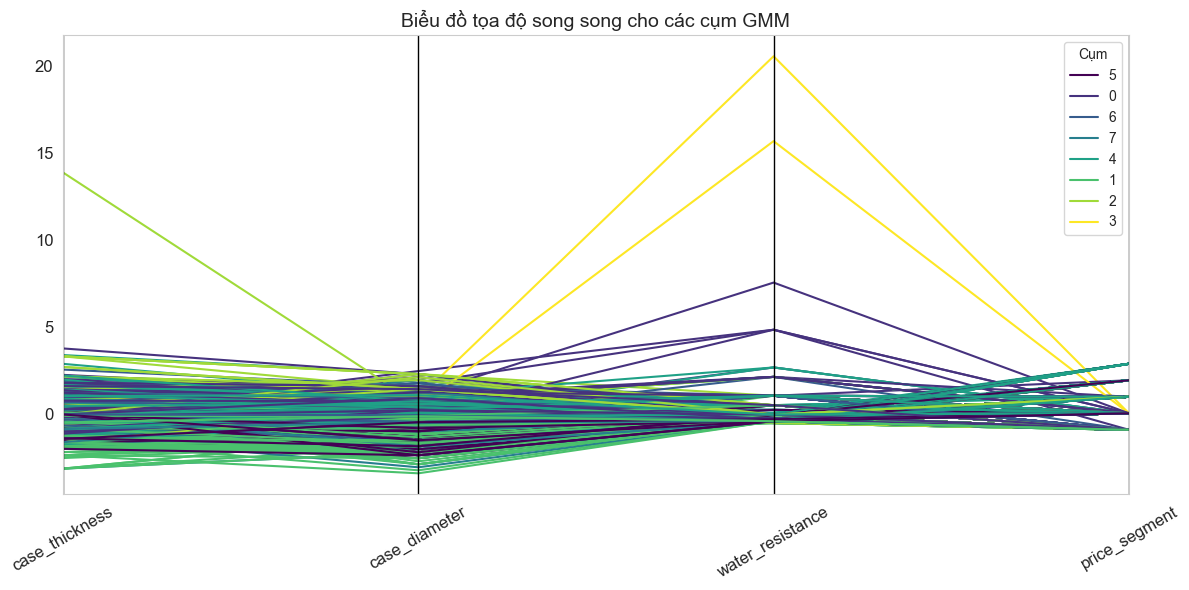

In [158]:
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

parallel_features = num_cols + ['price_segment']
sample_size = min(1000, len(df_original))
df_sample = df_original.sample(sample_size, random_state=42) if len(df_original) > sample_size else df_original
parallel_df = df_sample[parallel_features + ['gmm_cluster']].copy()
scaler = StandardScaler()
parallel_df[parallel_features] = scaler.fit_transform(parallel_df[parallel_features])

plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_df, 'gmm_cluster', colormap='viridis')
plt.title('Biểu đồ tọa độ song song cho các cụm GMM', fontsize=14)
plt.grid(False)
plt.legend(title='Cụm')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 8. Phân tích mối quan hệ giữa các đặc trưng số theo cụm GMM

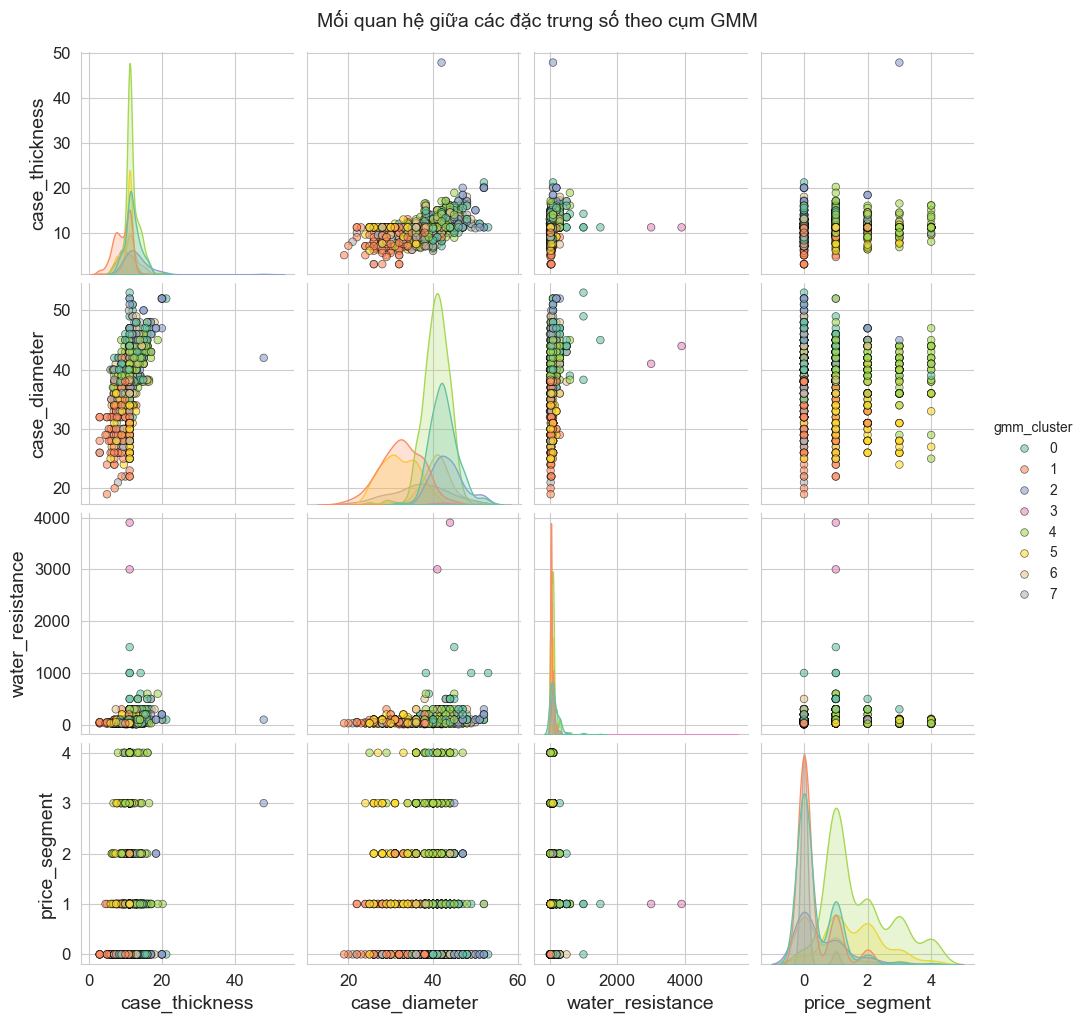

In [159]:
sns.pairplot(df_sample, vars=num_cols + ['price_segment'], hue='gmm_cluster', palette='Set2', 
             height=2.5, plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k', 'linewidth': 0.5})
plt.suptitle('Mối quan hệ giữa các đặc trưng số theo cụm GMM', y=1.02, fontsize=14)
plt.show()

## 9. Đặc điểm và phân loại các cụm GMM

Dựa trên các phân tích trên, bạn có thể mô tả đặc điểm từng cụm GMM tương tự như phần Agglomerative Clustering để so sánh.

Tóm tắt các cụm GMM:
   gmm_cluster  sample_count  percentage
0            4          1623   28.649603
1            0          1080   19.064431
2            1           812   14.333628
3            5           769   13.574581
4            6           508    8.967343
5            2           482    8.508385
6            7           385    6.796117
7            3             6    0.105914


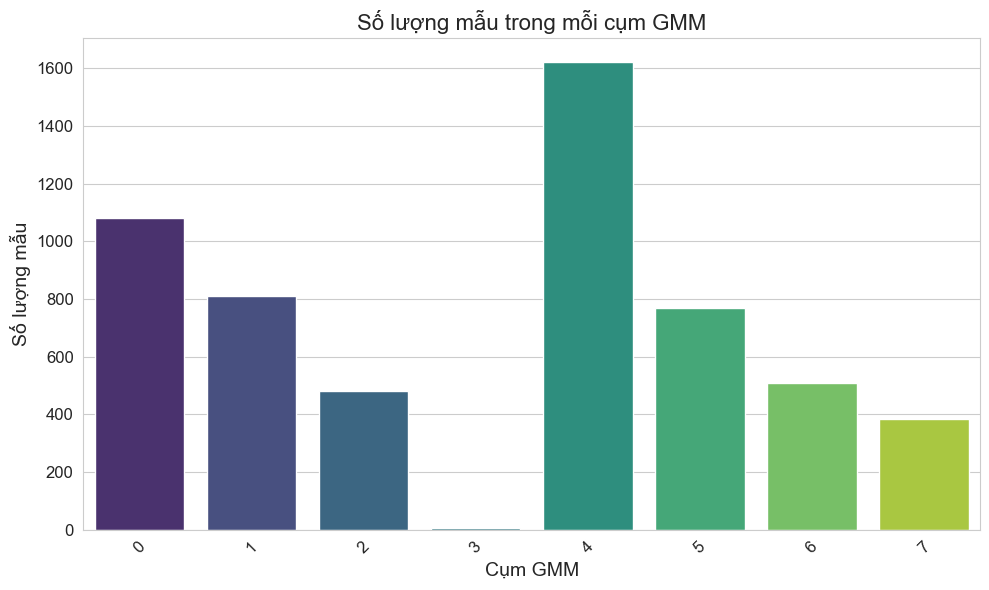


Đặc điểm cụm GMM 0:
       case_thickness  case_diameter  water_resistance  price_segment
count     1080.000000    1080.000000       1080.000000    1080.000000
mean        12.162932      42.763227        147.813060       0.332407
std          2.707548       3.561779        191.798679       0.628093
min          4.500000      27.000000          3.000000       0.000000
25%         11.000000      40.000000         50.000000       0.000000
50%         11.500000      42.000000        100.000000       0.000000
75%         13.462500      45.000000        200.000000       1.000000
max         29.500000      58.000000       2000.000000       4.000000


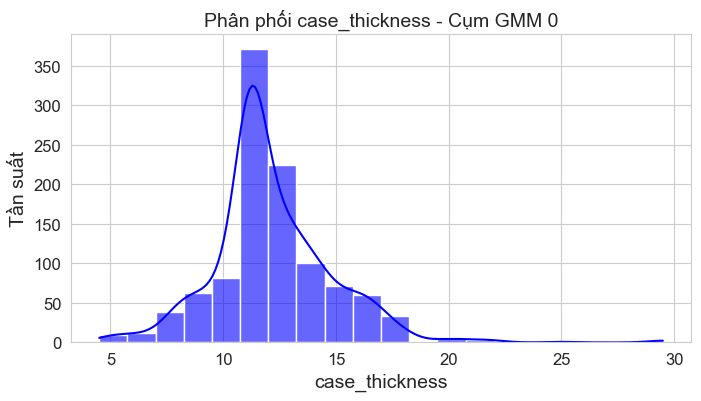

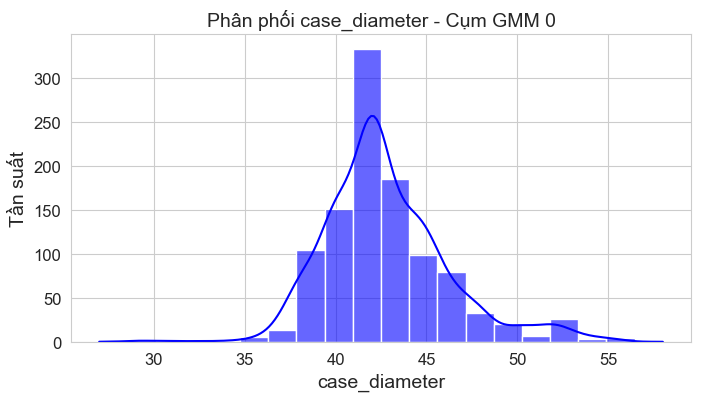

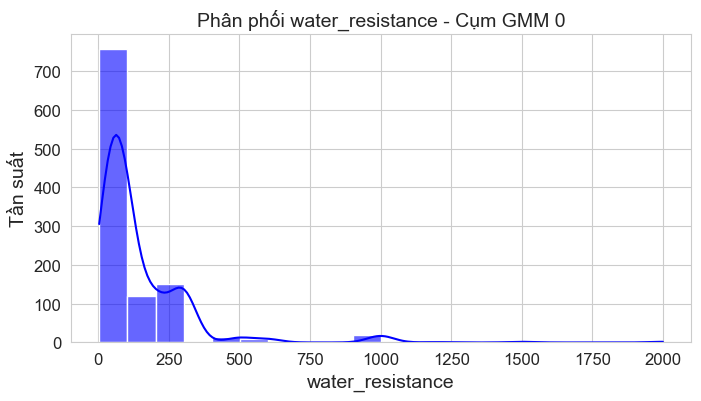


Đặc điểm cụm GMM 1:
       case_thickness  case_diameter  water_resistance  price_segment
count      812.000000     812.000000        812.000000     812.000000
mean         9.247342      32.068094         53.682801       0.311576
std          2.204043       4.837269         36.953968       0.564213
min          3.000000      12.000000          3.000000       0.000000
25%          7.800000      29.000000         30.000000       0.000000
50%          9.430000      32.000000         50.000000       0.000000
75%         11.196182      36.000000         50.000000       1.000000
max         17.000000      45.000000        300.000000       3.000000


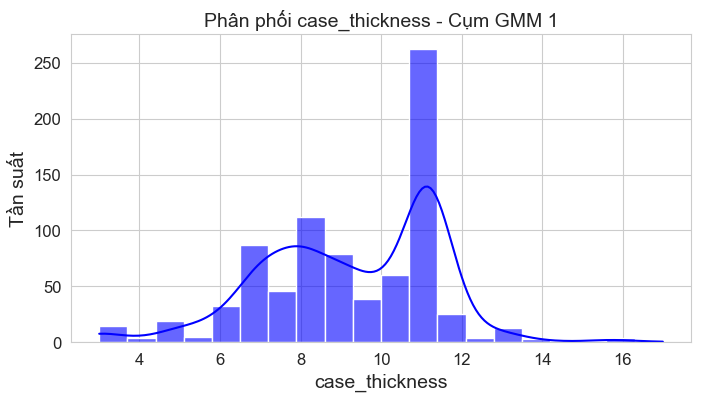

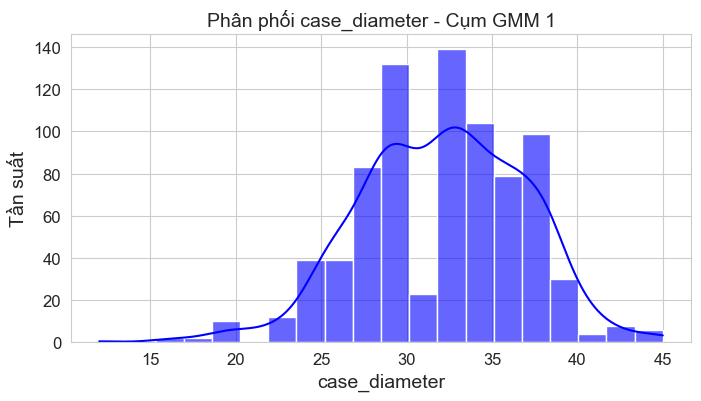

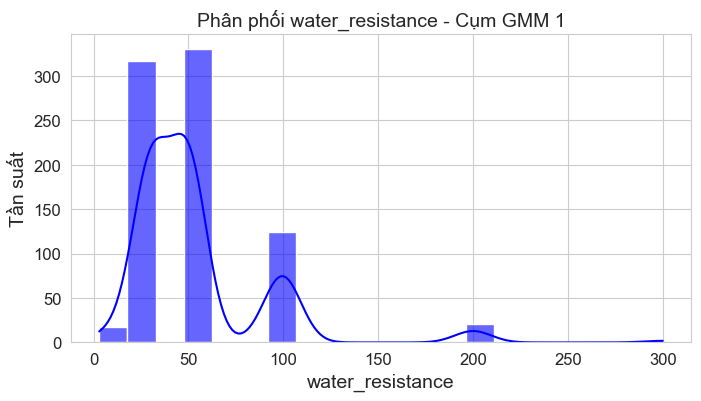


Đặc điểm cụm GMM 2:
       case_thickness  case_diameter  water_resistance  price_segment
count      482.000000     482.000000        482.000000     482.000000
mean        12.986049      43.015750        116.859604       0.510373
std          3.836381       4.175725         91.909545       0.709965
min          4.000000      12.000000         10.000000       0.000000
25%         11.196182      41.000000         50.000000       0.000000
50%         12.000000      43.000000        100.000000       0.000000
75%         14.237500      45.000000        100.000000       1.000000
max         66.200000      53.000000       1200.000000       4.000000


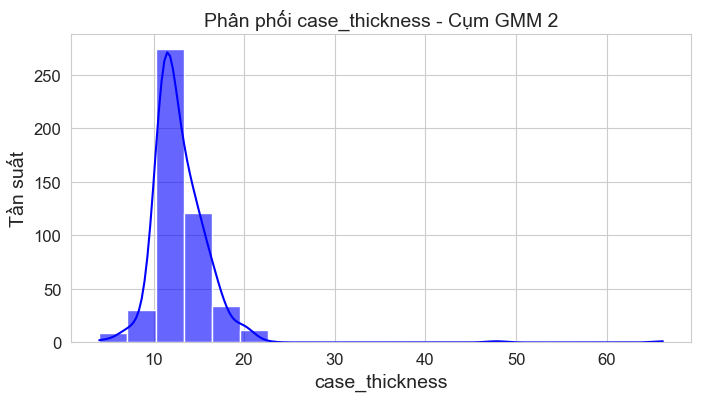

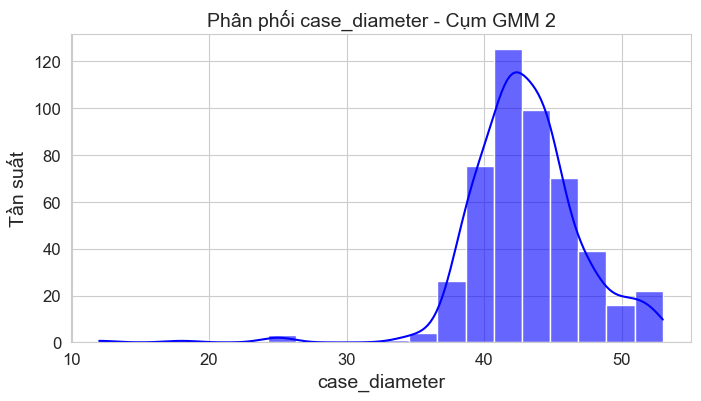

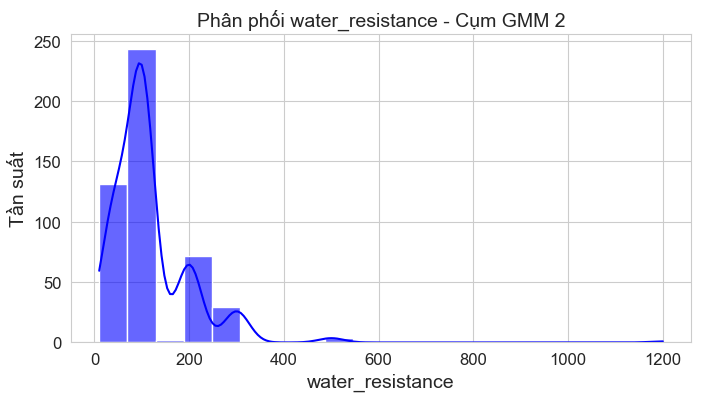


Đặc điểm cụm GMM 3:
       case_thickness  case_diameter  water_resistance  price_segment
count        6.000000       6.000000          6.000000       6.000000
mean        11.196182      43.666667       4100.000000       1.500000
std          0.000000       1.366260        997.997996       0.547723
min         11.196182      41.000000       3000.000000       1.000000
25%         11.196182      44.000000       3900.000000       1.000000
50%         11.196182      44.000000       3900.000000       1.500000
75%         11.196182      44.000000       3900.000000       2.000000
max         11.196182      45.000000       6000.000000       2.000000


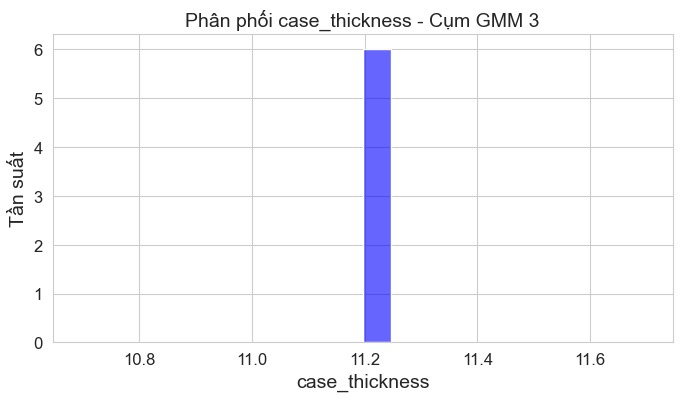

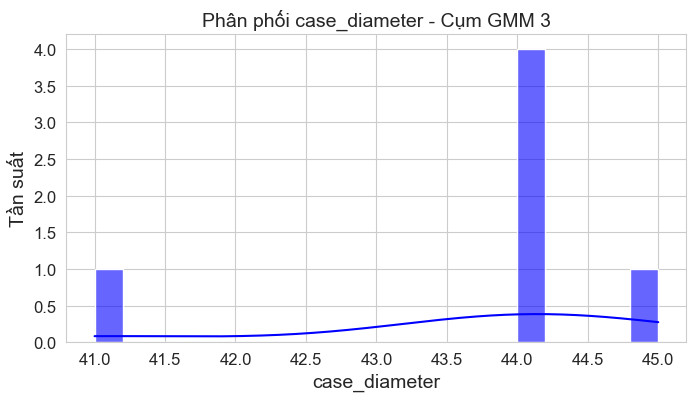

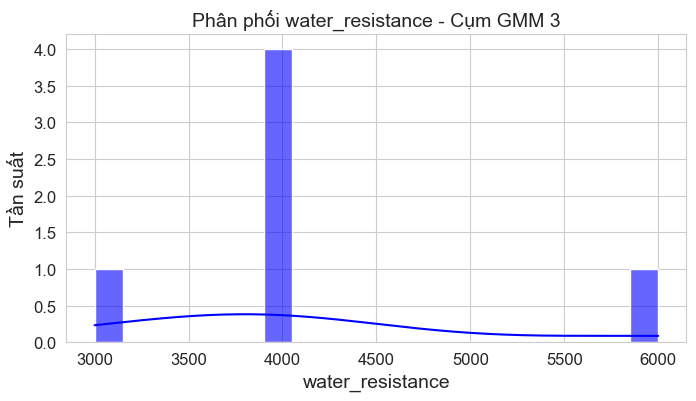


Đặc điểm cụm GMM 4:
       case_thickness  case_diameter  water_resistance  price_segment
count     1623.000000    1623.000000       1623.000000    1623.000000
mean        11.749817      40.758027         97.116702       1.804067
std          1.855646       3.091702         88.751218       1.029076
min          4.130000      23.000000          3.000000       0.000000
25%         11.196182      39.000000         30.000000       1.000000
50%         11.196182      41.000000        100.000000       2.000000
75%         12.650000      43.000000        100.000000       3.000000
max         20.200000      52.000000       1000.000000       4.000000


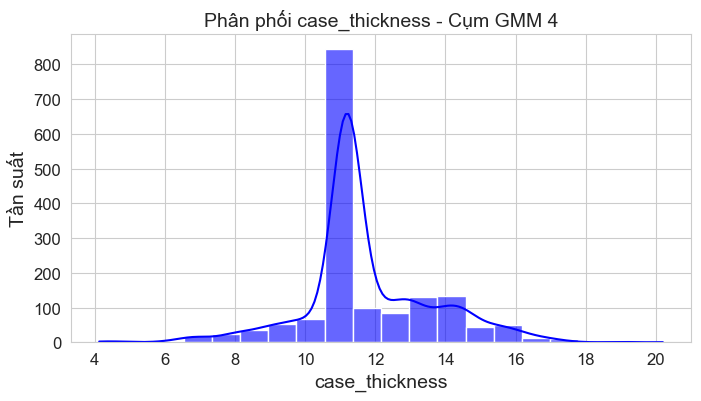

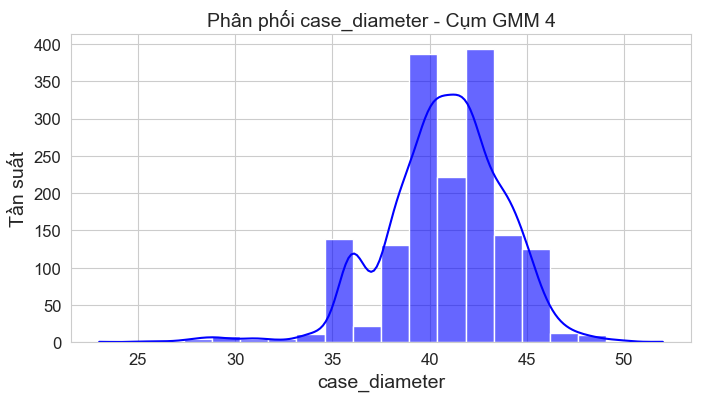

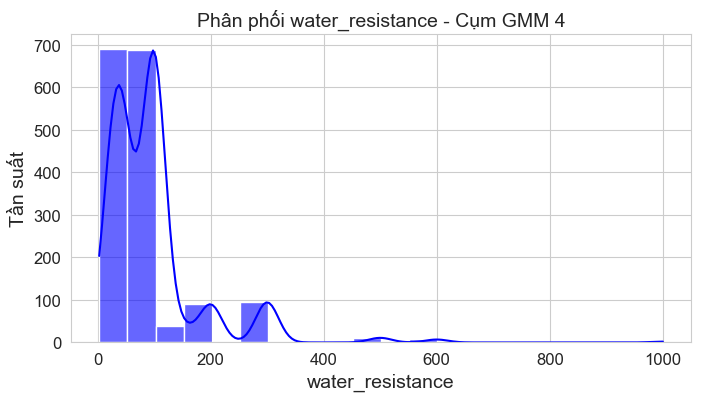


Đặc điểm cụm GMM 5:
       case_thickness  case_diameter  water_resistance  price_segment
count      769.000000     769.000000        769.000000     769.000000
mean        10.453950      31.630680         72.150032       1.732120
std          1.445628       4.346472         44.324297       0.923377
min          5.000000      17.000000         20.000000       0.000000
25%          9.950000      28.000000         30.000000       1.000000
50%         11.196182      31.000000         94.388151       2.000000
75%         11.196182      35.000000        100.000000       2.000000
max         14.000000      45.000000        500.000000       4.000000


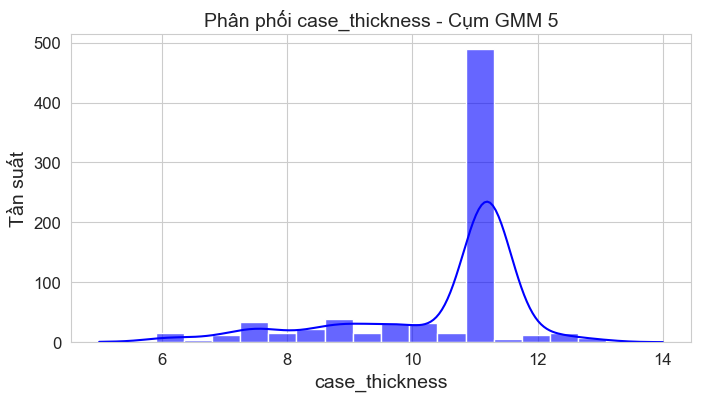

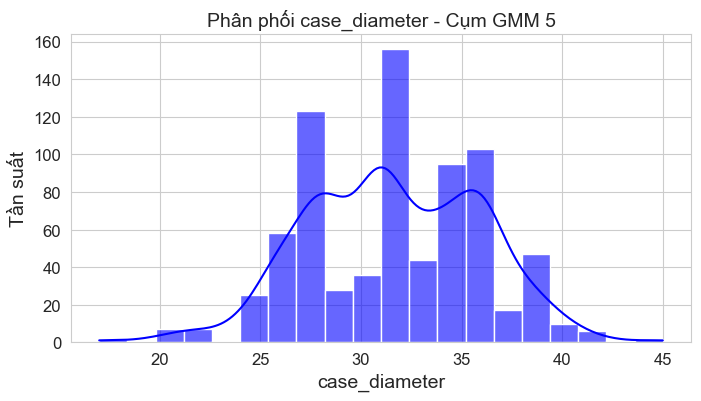

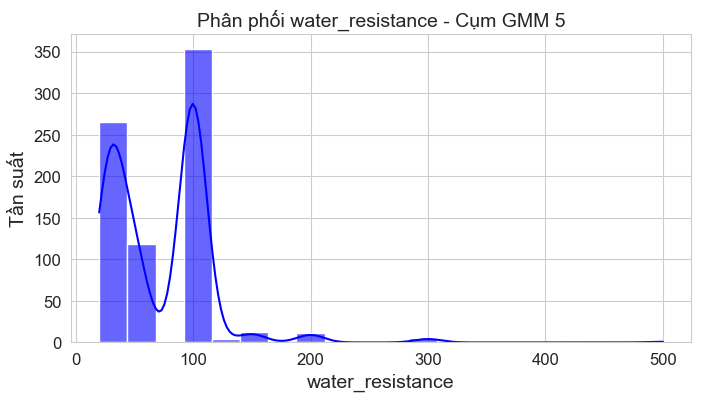


Đặc điểm cụm GMM 6:
       case_thickness  case_diameter  water_resistance  price_segment
count      508.000000     508.000000        508.000000     508.000000
mean        11.587525      40.749785         90.572278       0.521654
std          1.932109       3.834088         84.217812       0.831768
min          2.400000      21.000000         20.000000       0.000000
25%         11.000000      38.299276         50.000000       0.000000
50%         11.196182      41.000000         50.000000       0.000000
75%         12.600000      43.000000        100.000000       1.000000
max         22.500000      58.000000       1000.000000       4.000000


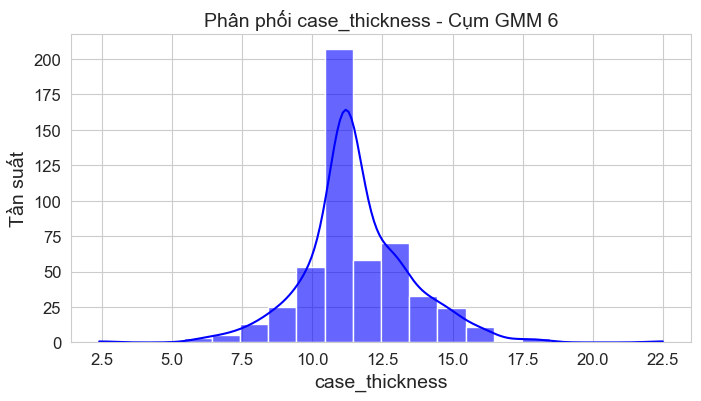

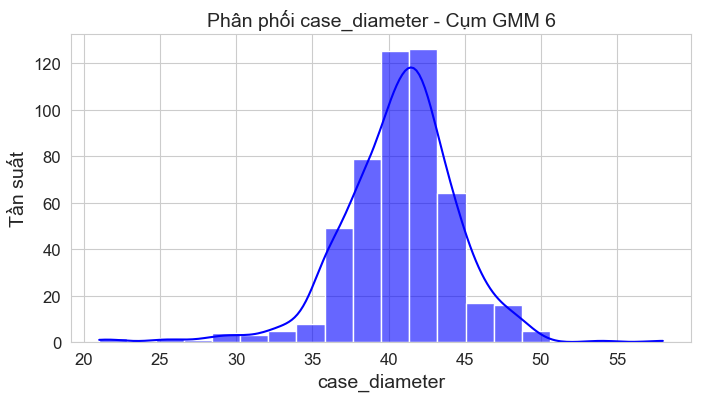

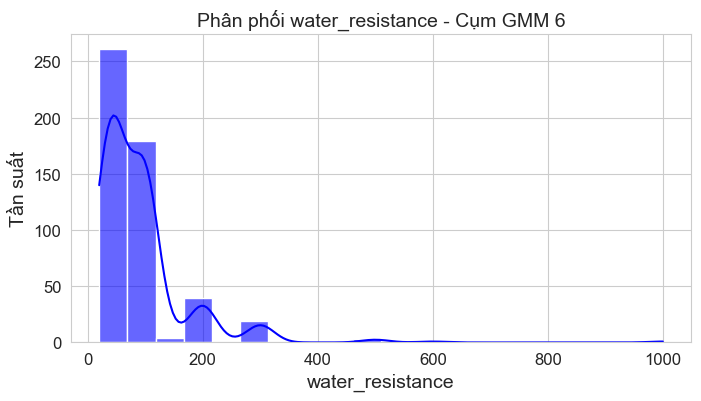


Đặc điểm cụm GMM 7:
       case_thickness  case_diameter  water_resistance  price_segment
count      385.000000     385.000000        385.000000     385.000000
mean         9.793252      36.791165         43.236364       0.077922
std          1.855993       5.538592         19.169304       0.359623
min          3.000000      21.000000          3.000000       0.000000
25%          8.500000      33.000000         30.000000       0.000000
50%          9.500000      36.000000         50.000000       0.000000
75%         11.196182      41.000000         50.000000       0.000000
max         15.000000      51.000000        100.000000       3.000000


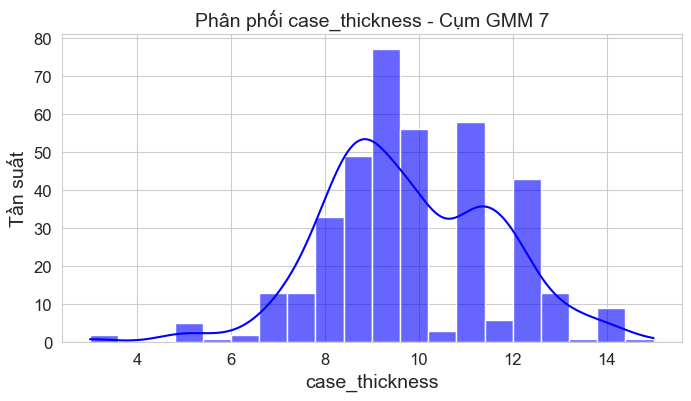

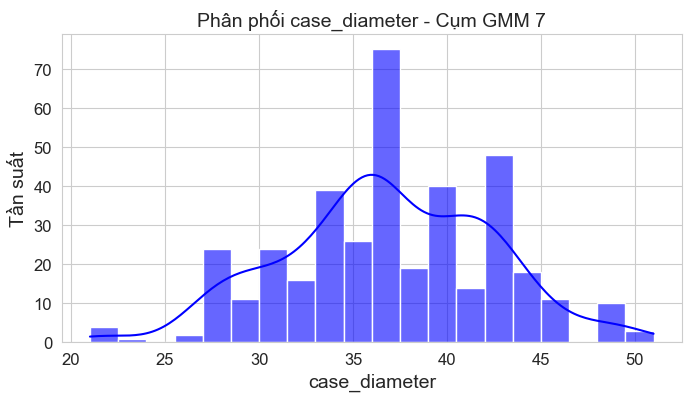

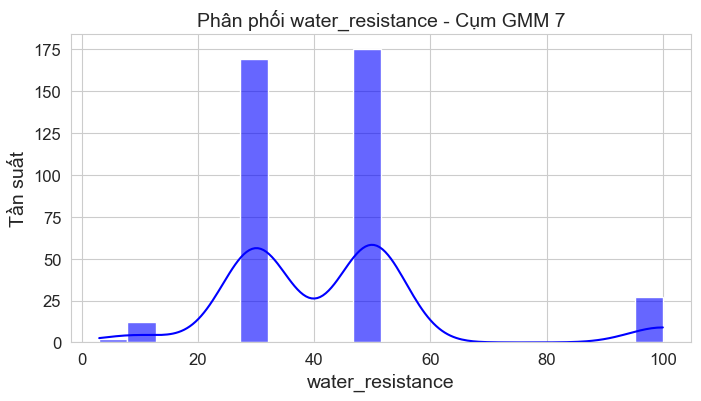

In [160]:
# Xuất danh sách các cụm GMM và số lượng mẫu trong mỗi cụm
gmm_cluster_counts = df_original['gmm_cluster'].value_counts().reset_index()
gmm_cluster_counts.columns = ['gmm_cluster', 'sample_count']

# Tính toán tỷ lệ phần trăm cho mỗi cụm
total_samples = len(df_original)
gmm_cluster_counts['percentage'] = (gmm_cluster_counts['sample_count'] / total_samples) * 100

# Sắp xếp theo thứ tự giảm dần của số lượng mẫu
gmm_cluster_counts = gmm_cluster_counts.sort_values(by='sample_count', ascending=False)

# Hiển thị bảng tóm tắt cụm GMM
print("Tóm tắt các cụm GMM:")
print(gmm_cluster_counts)

# Biểu đồ số lượng mẫu trong mỗi cụm GMM
plt.figure(figsize=(10, 6))
sns.barplot(data=gmm_cluster_counts, x='gmm_cluster', y='sample_count', palette='viridis')
plt.title('Số lượng mẫu trong mỗi cụm GMM', fontsize=16)
plt.xlabel('Cụm GMM')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Phân tích đặc điểm từng cụm GMM dựa trên các đặc trưng số
for cluster_id in sorted(df_original['gmm_cluster'].unique()):
    print(f"\nĐặc điểm cụm GMM {cluster_id}:")
    cluster_profile = df_original[df_original['gmm_cluster'] == cluster_id][num_cols + ['price_segment']]
    print(cluster_profile.describe())
    
    # Vẽ biểu đồ phân phối cho từng đặc trưng số
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(cluster_profile[col], bins=20, kde=True, color='blue', alpha=0.6)
        plt.title(f'Phân phối {col} - Cụm GMM {cluster_id}', fontsize=14)
        plt.xlabel(col)
        plt.ylabel('Tần suất')
        plt.grid(True)
        plt.show()

# Phân cụm dữ liệu đồng hồ bằng Agglomerative Clustering


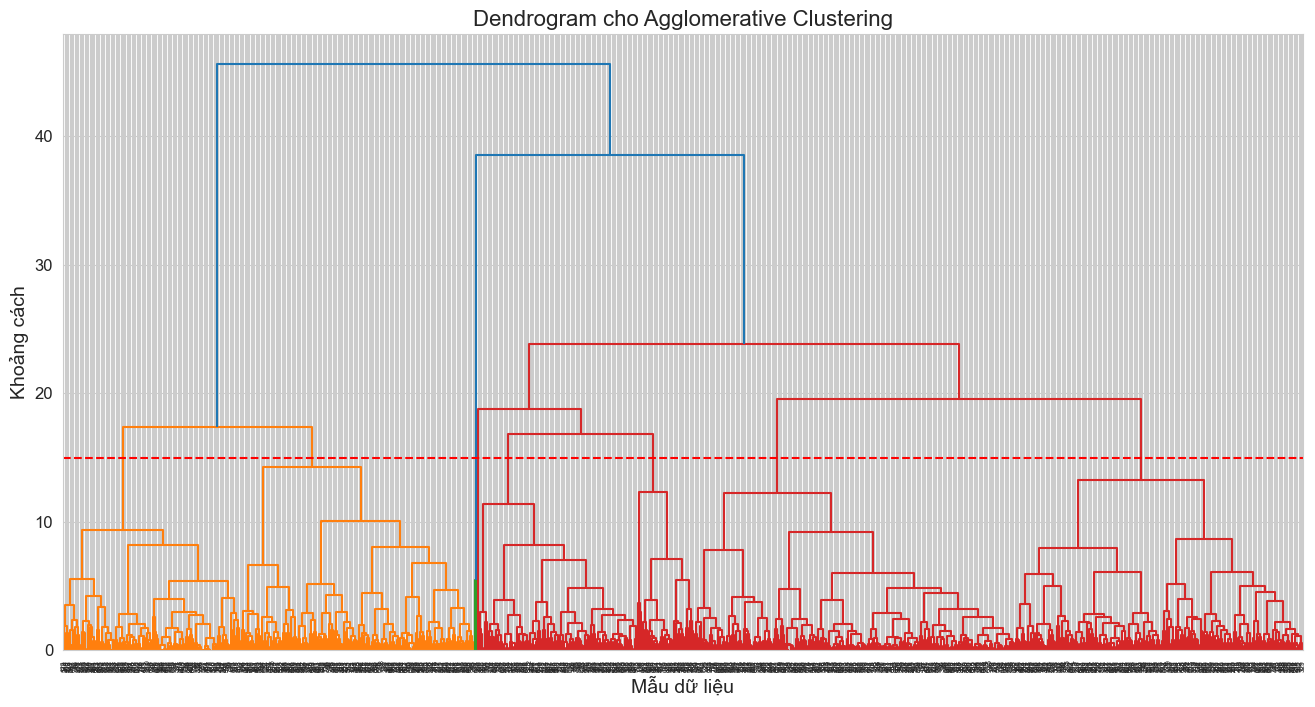

In [161]:
# Vẽ dendrogram để xác định số cụm tối ưu
plt.figure(figsize=(16, 8))
plt.title('Dendrogram cho Agglomerative Clustering', fontsize=16)
plt.xlabel('Mẫu dữ liệu', fontsize=14)
plt.ylabel('Khoảng cách', fontsize=14)

# Sử dụng mẫu nhỏ nếu dữ liệu quá lớn
sample_size = min(1000, len(df_agg))
sample_data = df_agg.sample(sample_size, random_state=42) if len(df_agg) > sample_size else df_agg

# Tính toán linkage matrix
linkage_matrix = linkage(sample_data, method='ward')

# Vẽ dendrogram
dendrogram(linkage_matrix)
plt.axhline(y=15, color='r', linestyle='--')  # Đường tham chiếu để chọn số cụm
plt.show()

n_clusters = 2:
  Silhouette Score: 0.2665
  Davies-Bouldin Score: 1.4043
  Calinski-Harabasz Score: 1754.2411
n_clusters = 3:
  Silhouette Score: 0.2723
  Davies-Bouldin Score: 1.0051
  Calinski-Harabasz Score: 1618.7676
n_clusters = 4:
  Silhouette Score: 0.1456
  Davies-Bouldin Score: 1.4441
  Calinski-Harabasz Score: 1415.9526
n_clusters = 5:
  Silhouette Score: 0.1540
  Davies-Bouldin Score: 1.3627
  Calinski-Harabasz Score: 1287.6890
n_clusters = 6:
  Silhouette Score: 0.1561
  Davies-Bouldin Score: 1.5424
  Calinski-Harabasz Score: 1176.9280
n_clusters = 7:
  Silhouette Score: 0.1432
  Davies-Bouldin Score: 1.6121
  Calinski-Harabasz Score: 1120.0489
n_clusters = 8:
  Silhouette Score: 0.1515
  Davies-Bouldin Score: 1.5445
  Calinski-Harabasz Score: 1048.8867


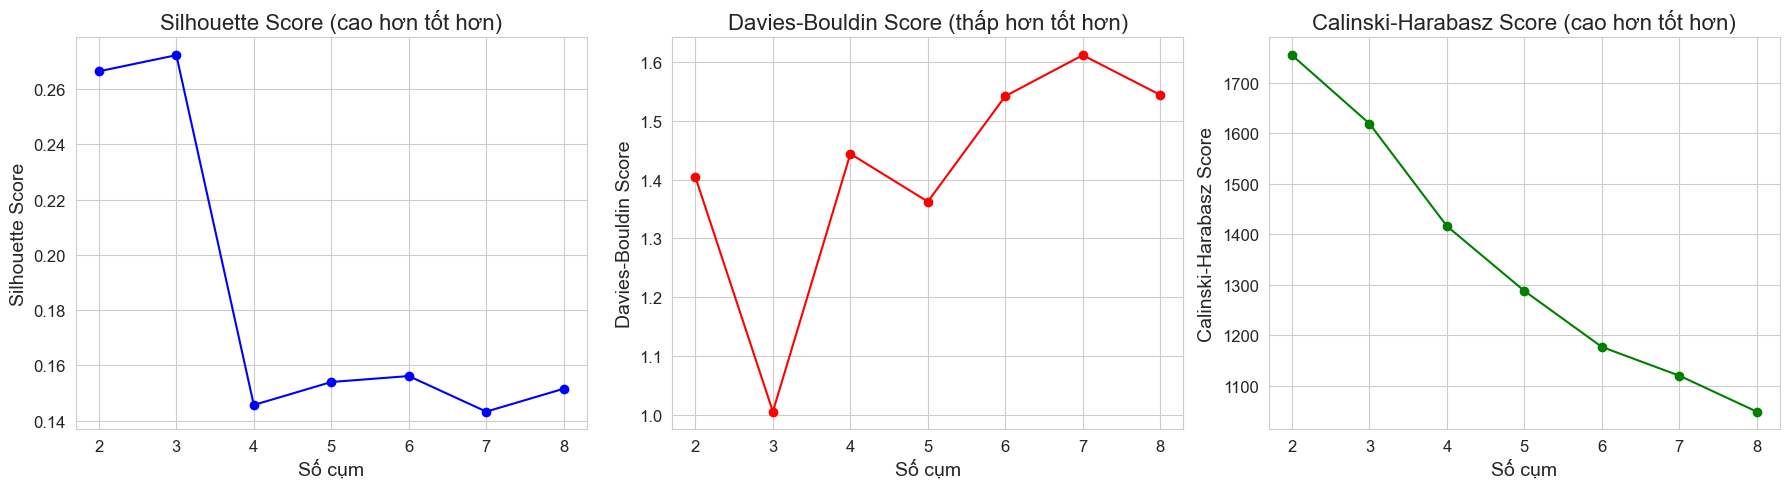

In [162]:
from sklearn.cluster import AgglomerativeClustering

# Thử nghiệm với một số lượng cụm khác nhau
n_clusters_list = [2, 3, 4, 5, 6, 7, 8]
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for n_clusters in n_clusters_list:
    # Áp dụng Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = agg_clustering.fit_predict(df_agg)
    
    # Tính các chỉ số đánh giá
    silhouette = silhouette_score(df_agg, cluster_labels)
    davies_bouldin = davies_bouldin_score(df_agg, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(df_agg, cluster_labels)
    
    # Lưu kết quả
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)
    
    print(f"n_clusters = {n_clusters}:")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz:.4f}")

# Vẽ biểu đồ kết quả
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(n_clusters_list, silhouette_scores, 'o-', color='blue')
ax[0].set_xlabel('Số cụm')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Score (cao hơn tốt hơn)')

ax[1].plot(n_clusters_list, davies_bouldin_scores, 'o-', color='red')
ax[1].set_xlabel('Số cụm')
ax[1].set_ylabel('Davies-Bouldin Score')
ax[1].set_title('Davies-Bouldin Score (thấp hơn tốt hơn)')

ax[2].plot(n_clusters_list, calinski_harabasz_scores, 'o-', color='green')
ax[2].set_xlabel('Số cụm')
ax[2].set_ylabel('Calinski-Harabasz Score')
ax[2].set_title('Calinski-Harabasz Score (cao hơn tốt hơn)')

plt.tight_layout()
plt.show()


Số cụm tối ưu dựa trên Silhouette Score: 3

=== PHÂN TÍCH PHÂN PHỐI CỦA CÁC CỤM ===
cluster
0    3801
1    1858
2       6
Name: count, dtype: int64

Phần trăm phân phối:
cluster
0    67.096205
1    32.797882
2     0.105914
Name: count, dtype: float64


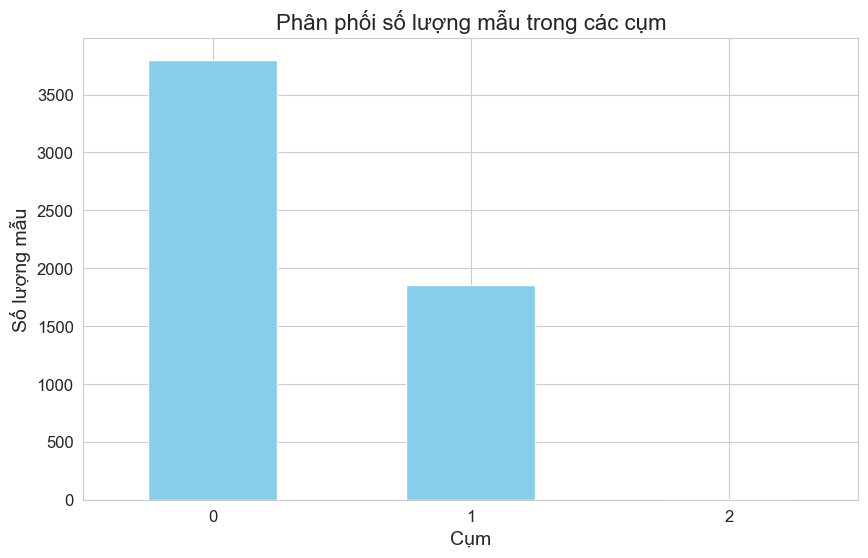

In [163]:
# Chọn số cụm tối ưu dựa trên kết quả
optimal_n_clusters = n_clusters_list[silhouette_scores.index(max(silhouette_scores))]
print(f"\nSố cụm tối ưu dựa trên Silhouette Score: {optimal_n_clusters}")

# Áp dụng Agglomerative Clustering với số cụm tối ưu
final_model = AgglomerativeClustering(n_clusters=optimal_n_clusters, linkage='ward')
df['cluster'] = final_model.fit_predict(df_agg)

# Phân tích kết quả phân cụm
print("\n=== PHÂN TÍCH PHÂN PHỐI CỦA CÁC CỤM ===")
cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)
print("\nPhần trăm phân phối:")
print(100 * cluster_counts / len(df))

# Trực quan hóa phân phối cụm
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Phân phối số lượng mẫu trong các cụm')
plt.xlabel('Cụm')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=0)
plt.show()



# So sánh các metrics


Agglomerative Clustering:
Silhouette Score: 0.2723
Davies-Bouldin Index: 1.0051
Calinski-Harabasz Index: 1618.7676


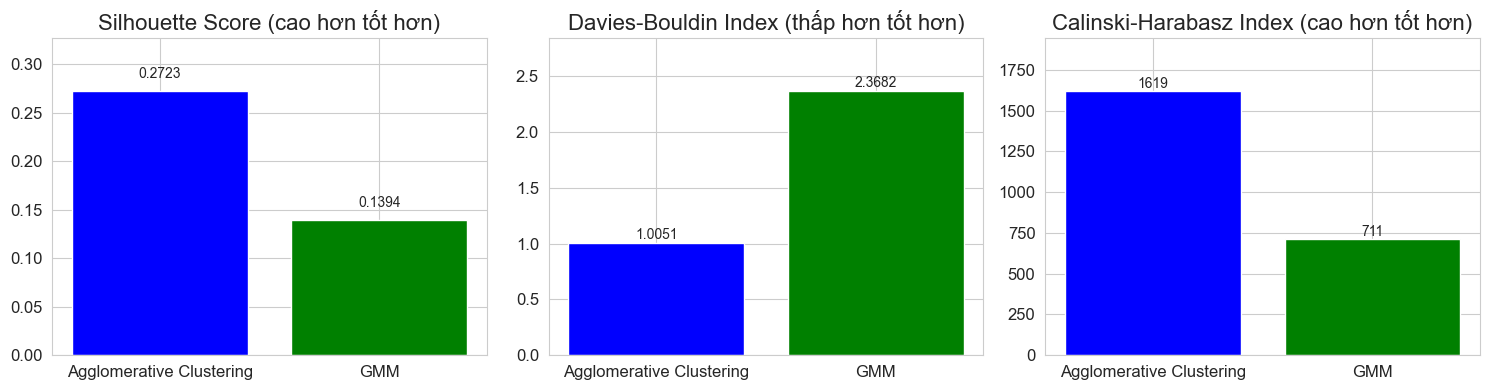


=== BẢNG KẾT QUẢ ĐÁNH GIÁ CÁC MÔ HÌNH ===
                      Model  Silhouette Score  Davies-Bouldin Index  \
0  Agglomerative Clustering          0.272319              1.005079   
1                       GMM          0.139379              2.368205   

   Calinski-Harabasz Index  
0              1618.767614  
1               711.087909  


In [164]:
metrics_results = []

# Tính metrics cho Agglomerative Clustering
silhouette = silhouette_score(df_agg, df['cluster'])
davies_bouldin = davies_bouldin_score(df_agg, df['cluster'])
calinski_harabasz = calinski_harabasz_score(df_agg, df['cluster'])

print(f"\nAgglomerative Clustering:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

metrics_results.append(['Agglomerative Clustering', silhouette, davies_bouldin, calinski_harabasz])

gmm_silhouette = silhouette_score(df_gmm, df_original['gmm_cluster'])
gmm_davies_bouldin = davies_bouldin_score(df_gmm, df_original['gmm_cluster'])
gmm_calinski_harabasz = calinski_harabasz_score(df_gmm, df_original['gmm_cluster'])

# Cập nhật bảng metrics để bao gồm GMM
metrics_results.append(['GMM', gmm_silhouette, gmm_davies_bouldin, gmm_calinski_harabasz])

# Tạo DataFrame để hiển thị kết quả
metrics_df = pd.DataFrame(metrics_results, 
                         columns=['Model', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# Vẽ biểu đồ so sánh Silhouette Score
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
bars = plt.bar(metrics_df['Model'], metrics_df['Silhouette Score'], color=['blue', 'green'])
plt.title('Silhouette Score (cao hơn tốt hơn)')
plt.ylim(0, max(metrics_df['Silhouette Score'][~np.isnan(metrics_df['Silhouette Score'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

# Vẽ biểu đồ so sánh Davies-Bouldin Index
plt.subplot(1, 3, 2)
bars = plt.bar(metrics_df['Model'], metrics_df['Davies-Bouldin Index'], color=['blue', 'green'])
plt.title('Davies-Bouldin Index (thấp hơn tốt hơn)')
plt.ylim(0, max(metrics_df['Davies-Bouldin Index'][~np.isnan(metrics_df['Davies-Bouldin Index'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

# Vẽ biểu đồ so sánh Calinski-Harabasz Index
plt.subplot(1, 3, 3)
bars = plt.bar(metrics_df['Model'], metrics_df['Calinski-Harabasz Index'], color=['blue', 'green'])
plt.title('Calinski-Harabasz Index (cao hơn tốt hơn)')
plt.ylim(0, max(metrics_df['Calinski-Harabasz Index'][~np.isnan(metrics_df['Calinski-Harabasz Index'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Hiển thị bảng kết quả đánh giá
print("\n=== BẢNG KẾT QUẢ ĐÁNH GIÁ CÁC MÔ HÌNH ===")
print(metrics_df)